# Let's looks for correlations beetween places ocupacy and infected cases
## Huge work in progress, please don't take this investigation too seriusly yet, is highly exprorative

 - Mobility data [from google](https://www.google.com/covid19/mobility/), and was [ripped here](https://github.com/verasativa/covi-19-chile/blob/master/Google-community-mobility-report-extrator/gcmr.csv).
 - Infections in Chile data from [Allkun Analitica's datastudio](https://datastudio.google.com/u/0/reporting/1oTmHXjhKFfvmetVm7ktujAlZAPLYCiac/page/iFHJB) dashboard.

## Data cooking

In [9]:
#Cargamos datos de infecciones
import pandas as pd

colmap = {
    'Evolución acumulada de casos': 'total_cases',
    'Evolución de nuevos casos': 'new_cases'
}
idf = pd.read_csv('covid19_cl_Resumen Allkun Analítica_Gráfico combinado.csv').rename(columns=colmap)

# Pongamos fechas bonitas
import datetime

def nday2datetime(nday):
    base_date = datetime.datetime(2020, 3, 2)
    return base_date + datetime.timedelta(days=nday)

def nday2datetime_list(nday_list):
    result = []
    for nday in nday_list:
        result.append(nday2datetime(nday))
        
    return result


idf['ds'] = pd.Series(idf.index).apply(nday2datetime)
idf.set_index('ds', inplace=True)

idf.head()

fechainiciosintoma  total_cases  new_cases
ds                                                   
2020-03-02        2 mar. 2020            1          1
2020-03-03        3 mar. 2020            1          1
2020-03-04        4 mar. 2020            2          2
2020-03-05        5 mar. 2020            2          2
2020-03-06        7 mar. 2020            1          1

In [18]:
# Cargamos mobilidad

mdf = pd.read_feather('Google-community-mobility-report-extrator/gcmr.feather')
mdf.set_index('date', inplace=True)
mdf.head()

Residential  Grocery & pharmacy     Parks  Retail - recreation  \
date                                                                         
2020-02-16     0.000000            0.050146  0.047114             0.032653   
2020-02-17     0.008163            0.055044  0.109155             0.009096   
2020-02-18     0.009563            0.050612  0.125015             0.002332   
2020-02-19     0.009563            0.075569  0.108455            -0.003265   
2020-02-20     0.009796            0.051312  0.114286            -0.014927   

            Workplaces  Transit stations  
date                                      
2020-02-16   -0.005831          0.042682  
2020-02-17   -0.076968         -0.030787  
2020-02-18   -0.068105         -0.026822  
2020-02-19   -0.066006         -0.031020  
2020-02-20   -0.067405         -0.027522

In [104]:
import datetime

deltas = []
for i in range(3, 16):
    delta = datetime.timedelta(days=i)
    deltas.append(delta)
#deltas

In [89]:
def add_mobility(row):
    for delta in deltas:
        for place, rate in mdf.loc[row.name.date() - delta].items():
            row[f'{place}_d{delta.days:02}'] = rate
        
    return row
    
idf.sample(n=3).apply(add_mobility, axis=1)

fechainiciosintoma  total_cases  new_cases  Residential_d03  \
ds                                                                       
2020-03-17       20 mar. 2020           92         92         0.030787   
2020-03-24       27 mar. 2020          304        304         0.220408   
2020-03-21       24 mar. 2020          176        176         0.142507   

            Grocery & pharmacy_d03  Parks_d03  Retail - recreation_d03  \
ds                                                                       
2020-03-17                0.088397  -0.210612                 0.009563   
2020-03-24               -0.314402  -0.659825                -0.629038   
2020-03-21                0.020758  -0.451545                -0.377376   

            Workplaces_d03  Transit stations_d03  Residential_d04  ...  \
ds                                                                 ...   
2020-03-17        0.035452             -0.010029        -0.007464  ...   
2020-03-24       -0.323032             -0.504956         0.225773  ...   
2020-03-21       -0.182624             -0.323732         0.111720  ...   

            Parks_d14  Retail - recreation_d14  Workplaces_d14  \
ds                                                               
2020-03-17  -0.144373                 0.044781        0.124315   
2020-03-24  -0.170962                -0.025423        0.173061   
2020-03-21  -0.196152                 0.065539        0.033586   

            Transit stations_d14  Residential_d15  Grocery & pharmacy_d15  \
ds                                                                          
2020-03-17              0.032420         0.001399                0.089096   
2020-03-24              0.069271        -0.004665                0.020991   
2020-03-21              0.015160        -0.001866                0.046647   

            Parks_d15  Retail - recreation_d15  Workplaces_d15  \
ds                                                               
2020-03-17  -0.145773                 0.046880        0.112886   
2020-03-24  -0.134111                -0.031720        0.164198   
2020-03-21  -0.124781                 0.006531        0.158601   

            Transit stations_d15  
ds                                
2020-03-17              0.021458  
2020-03-24              0.045015  
2020-03-21              0.035918  

[3 rows x 81 columns]

# Kind of works, let's try to regress it

In [94]:
df = idf.apply(add_mobility, axis=1).drop(columns=['fechainiciosintoma'])
df['_count'] = df.reset_index().index.values
df = df.reindex(sorted(df.columns), axis=1)

df.head()

Grocery & pharmacy_d03  Grocery & pharmacy_d04  \
ds                                                           
2020-03-02                0.085364                0.031020   
2020-03-03                0.120816                0.085364   
2020-03-04                0.153936                0.120816   
2020-03-05                0.089096                0.153936   
2020-03-06                0.100292                0.089096   

            Grocery & pharmacy_d05  Grocery & pharmacy_d06  \
ds                                                           
2020-03-02                0.028455                0.032187   
2020-03-03                0.031020                0.028455   
2020-03-04                0.085364                0.031020   
2020-03-05                0.120816                0.085364   
2020-03-06                0.153936                0.120816   

            Grocery & pharmacy_d07  Grocery & pharmacy_d08  \
ds                                                           
2020-03-02                0.027988                0.043382   
2020-03-03                0.032187                0.027988   
2020-03-04                0.028455                0.032187   
2020-03-05                0.031020                0.028455   
2020-03-06                0.085364                0.031020   

            Grocery & pharmacy_d09  Grocery & pharmacy_d10  \
ds                                                           
2020-03-02                0.046647                0.050146   
2020-03-03                0.043382                0.046647   
2020-03-04                0.027988                0.043382   
2020-03-05                0.032187                0.027988   
2020-03-06                0.028455                0.032187   

            Grocery & pharmacy_d11  Grocery & pharmacy_d12  ...  \
ds                                                          ...   
2020-03-02                0.051312                0.075569  ...   
2020-03-03                0.050146                0.051312  ...   
2020-03-04                0.046647                0.050146  ...   
2020-03-05                0.043382                0.046647  ...   
2020-03-06                0.027988                0.043382  ...   

            Workplaces_d09  Workplaces_d10  Workplaces_d11  Workplaces_d12  \
ds                                                                           
2020-03-02       -0.021924       -0.070204       -0.067405       -0.066006   
2020-03-03       -0.017259       -0.021924       -0.070204       -0.067405   
2020-03-04       -0.023324       -0.017259       -0.021924       -0.070204   
2020-03-05       -0.010262       -0.023324       -0.017259       -0.021924   
2020-03-06        0.002099       -0.010262       -0.023324       -0.017259   

            Workplaces_d13  Workplaces_d14  Workplaces_d15  _count  new_cases  \
ds                                                                              
2020-03-02       -0.068105       -0.076968       -0.005831       0          1   
2020-03-03       -0.066006       -0.068105       -0.076968       1          1   
2020-03-04       -0.067405       -0.066006       -0.068105       2          2   
2020-03-05       -0.070204       -0.067405       -0.066006       3          2   
2020-03-06       -0.021924       -0.070204       -0.067405       4          1   

            total_cases  
ds                       
2020-03-02            1  
2020-03-03            1  
2020-03-04            2  
2020-03-05            2  
2020-03-06            1  

[5 rows x 81 columns]

In [97]:
X = df[df.columns[:-2]]
y = df.new_cases

In [99]:
from pygam import LinearGAM, s, f

gam = LinearGAM()
gam.fit(X, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22) + s(23) + s(24) + s(25) + s(26) + s(27) + s(28) + s(29) + s(30) + s(31) + s(32) + s(33) + s(34) + s(35) + s(36) + s(37) + s(38) + s(39) + s(40) + s(41) + s(42) + s(43) + s(44) + s(45) + s(46) + s(47) + s(48) + s(49) + s(50) + s(51) + s(52) + s(53) + s(54) + s(55) + s(56) + s(57) + s(58) + s(59) + s(60) + s(61) + s(62) + s(63) + s(64) + s(65) + s(66) + s(67) + s(68) + s(69) + s(70) + s(71) + s(72) + s(73) + s(74) + s(75) + s(76) + s(77) + s(78) + intercept,
   tol=0.0001, verbose=False)

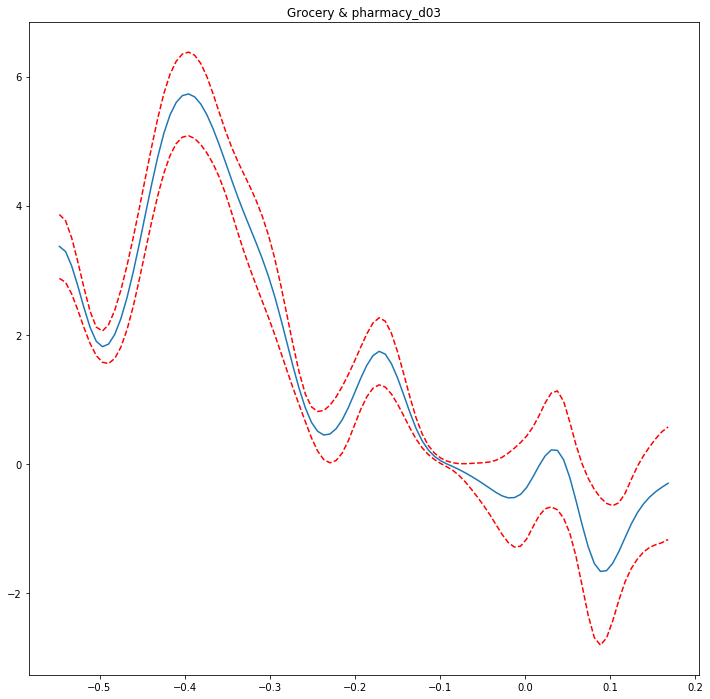

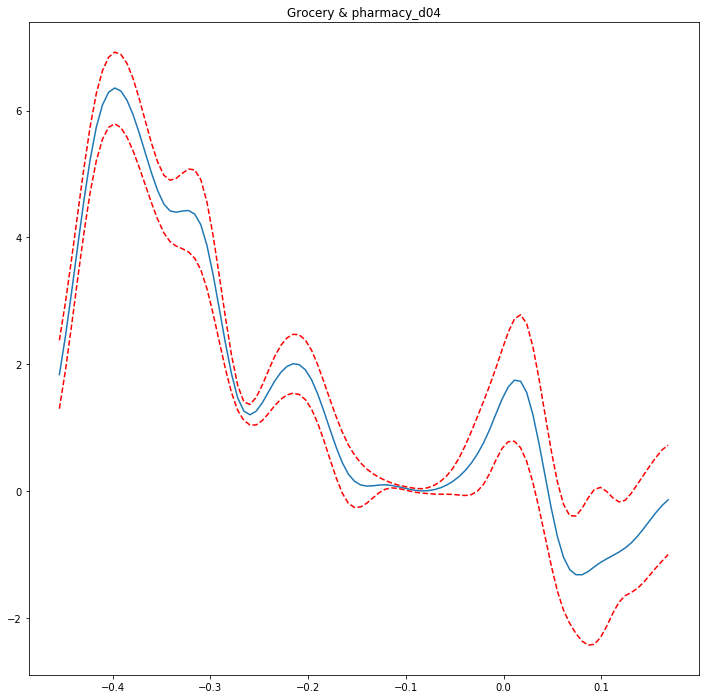

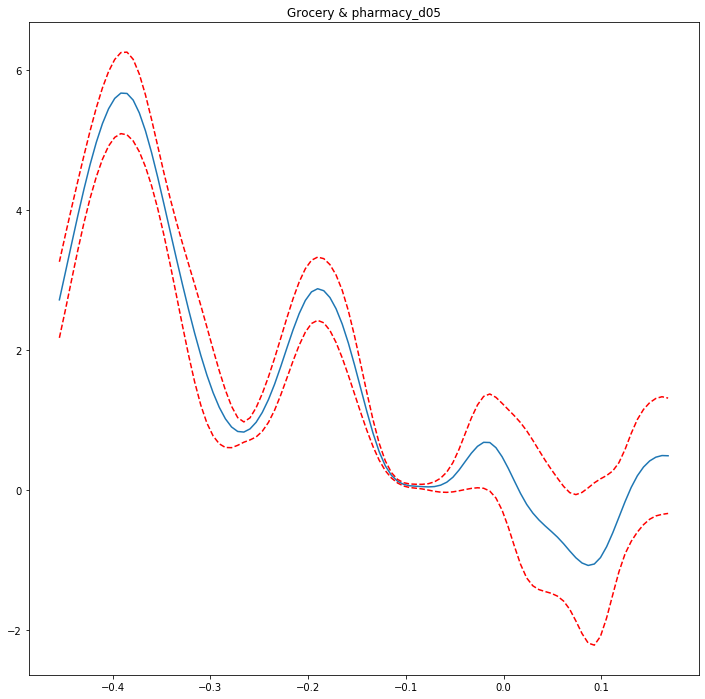

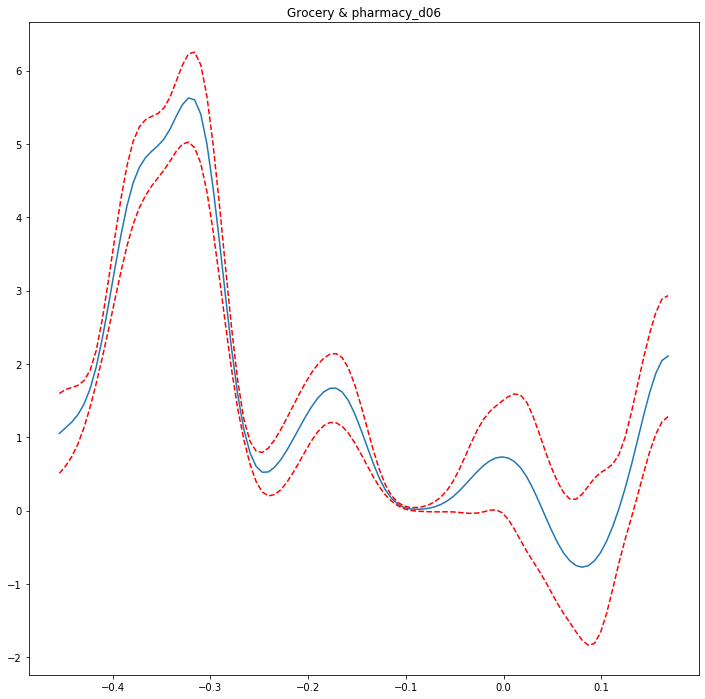

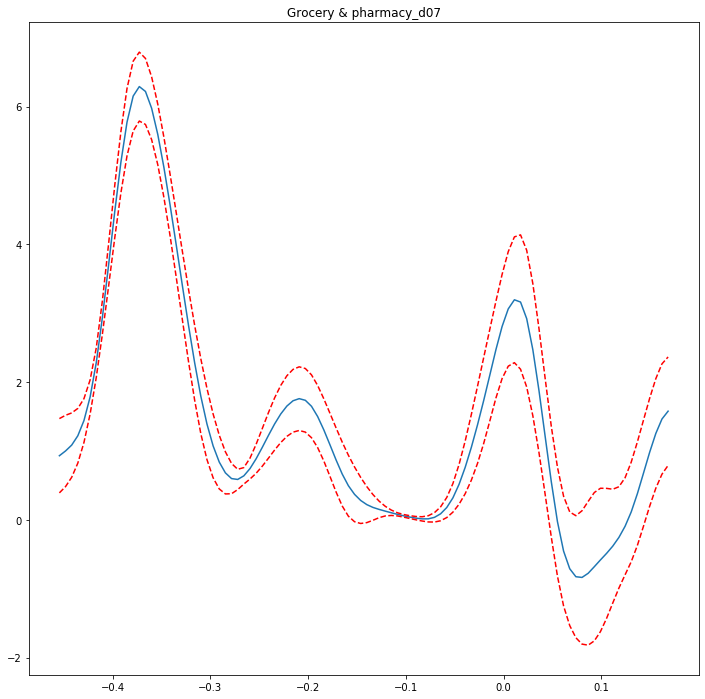

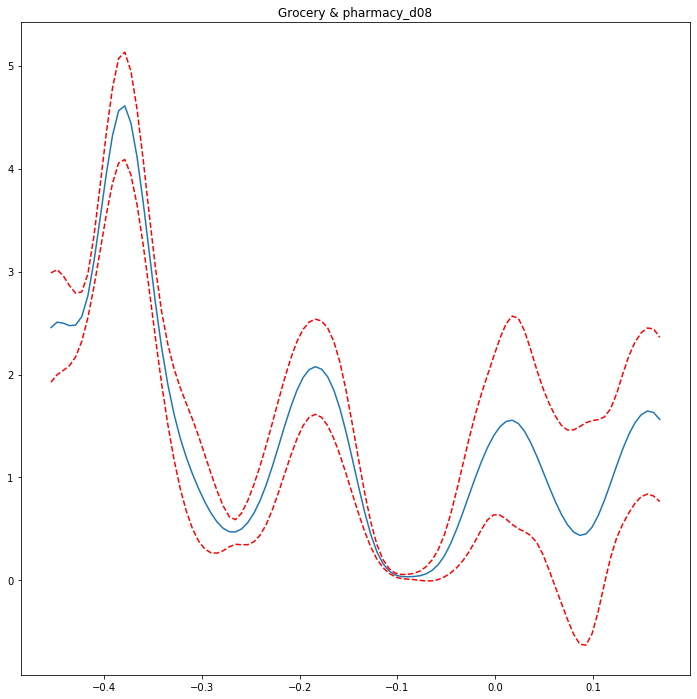

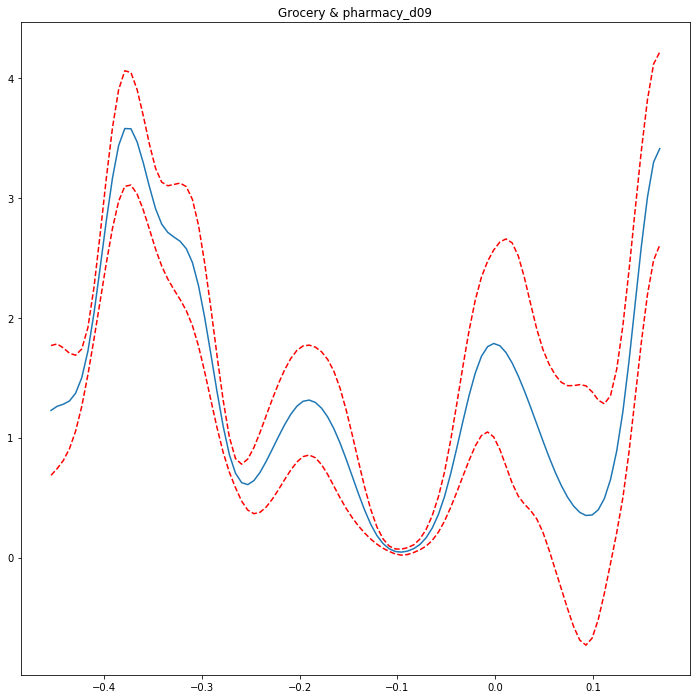

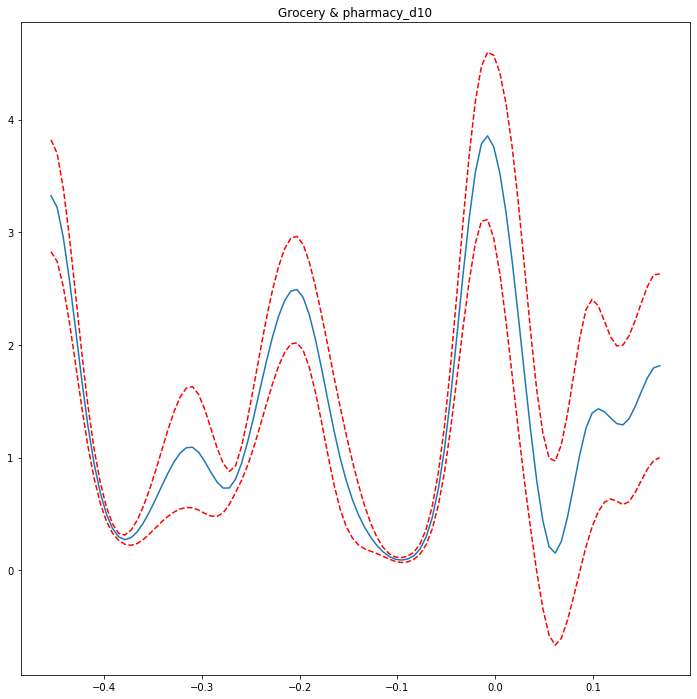

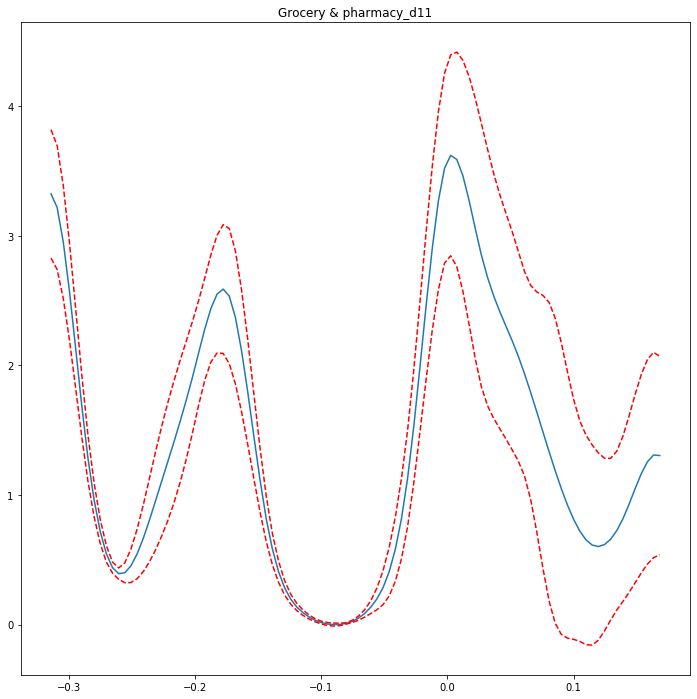

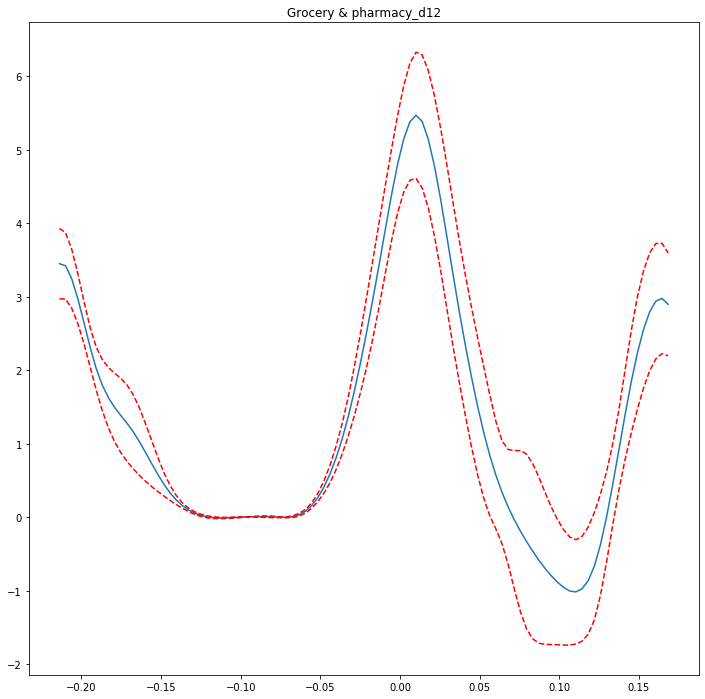

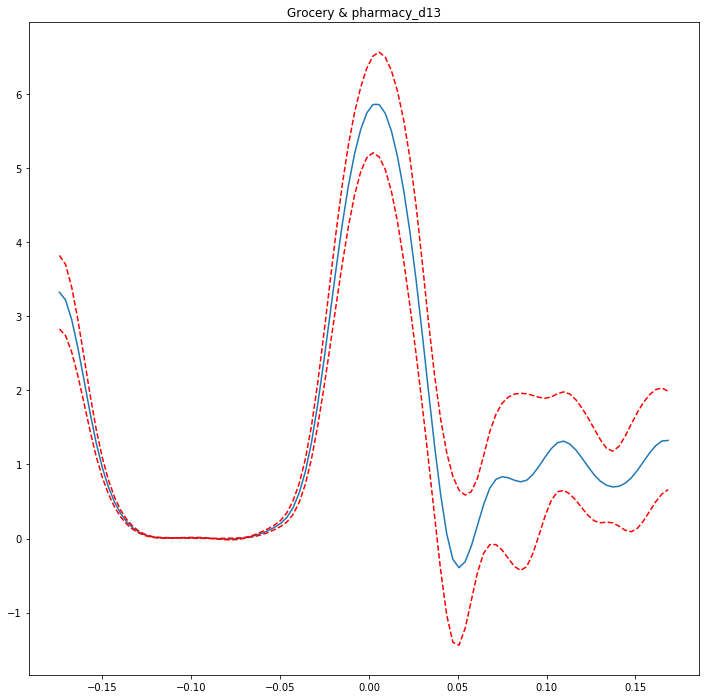

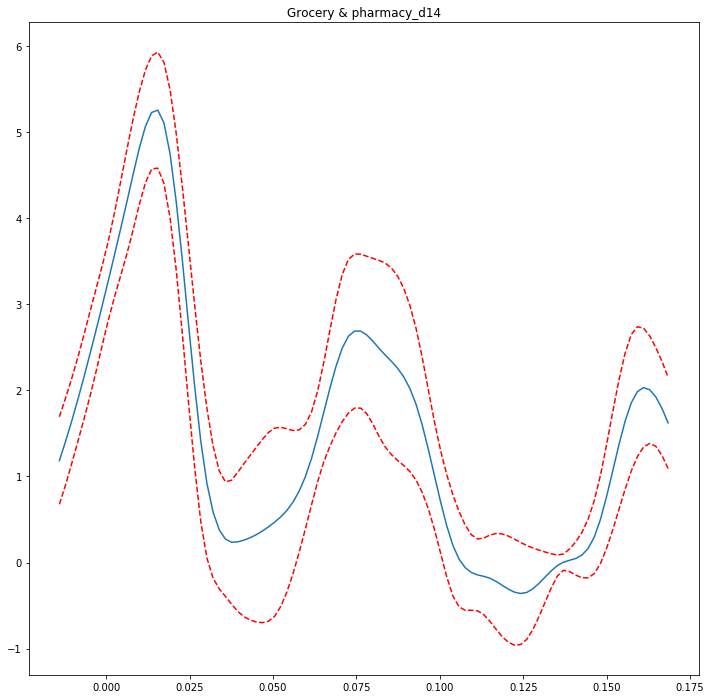

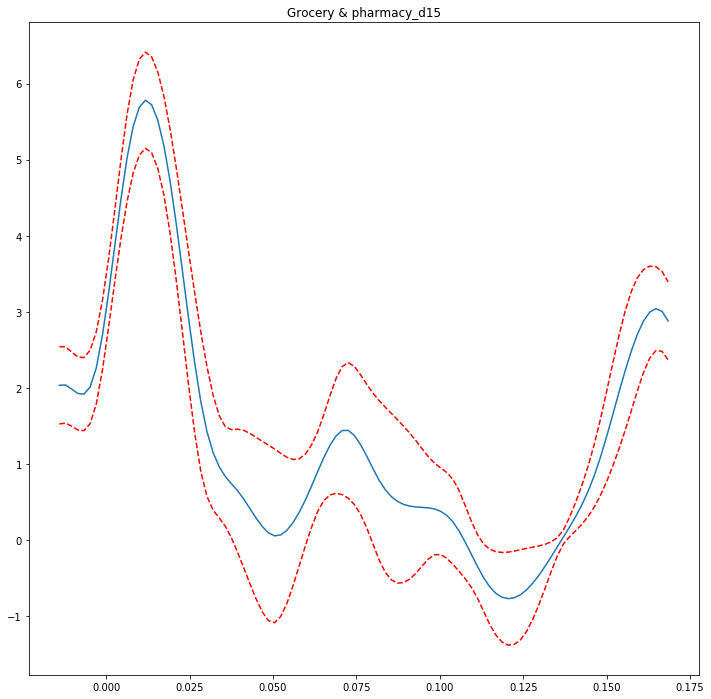

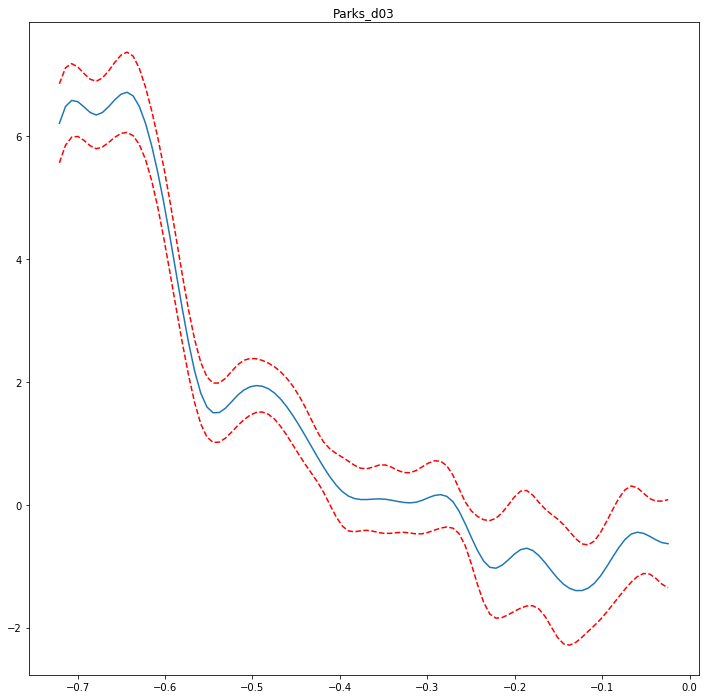

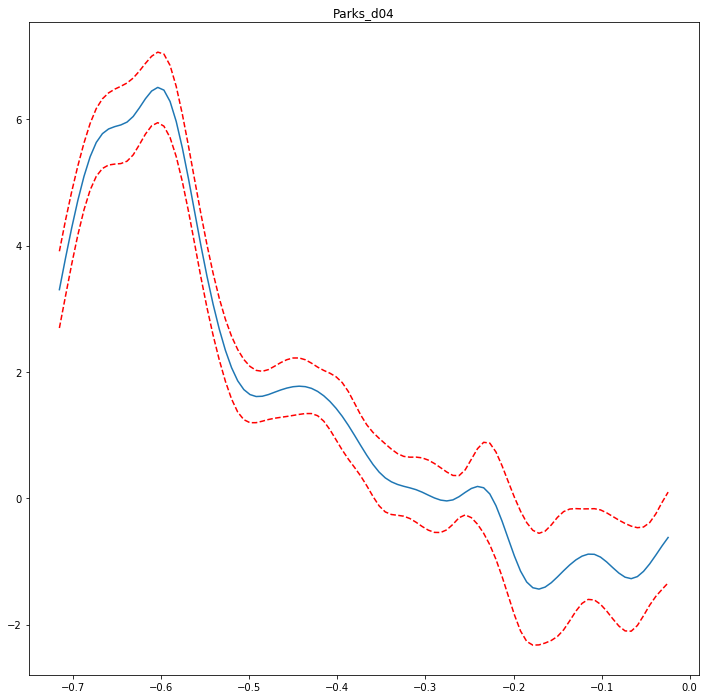

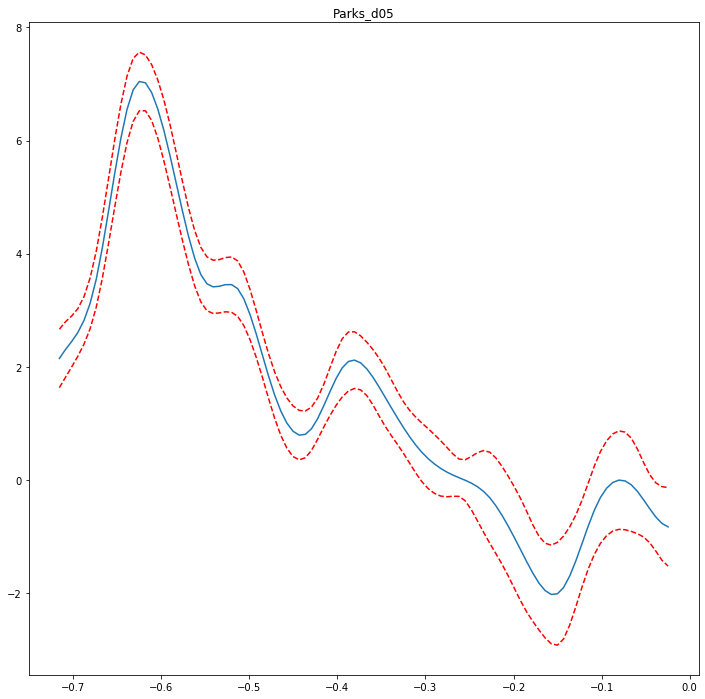

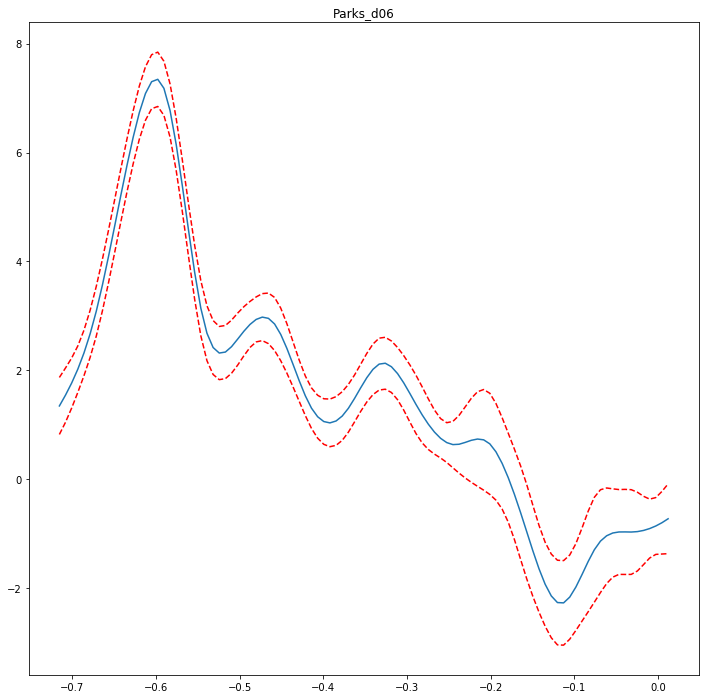

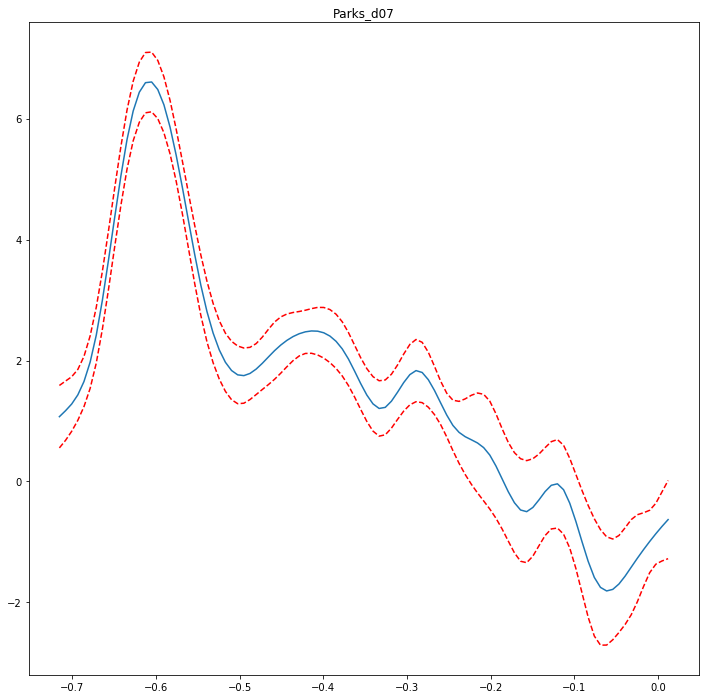

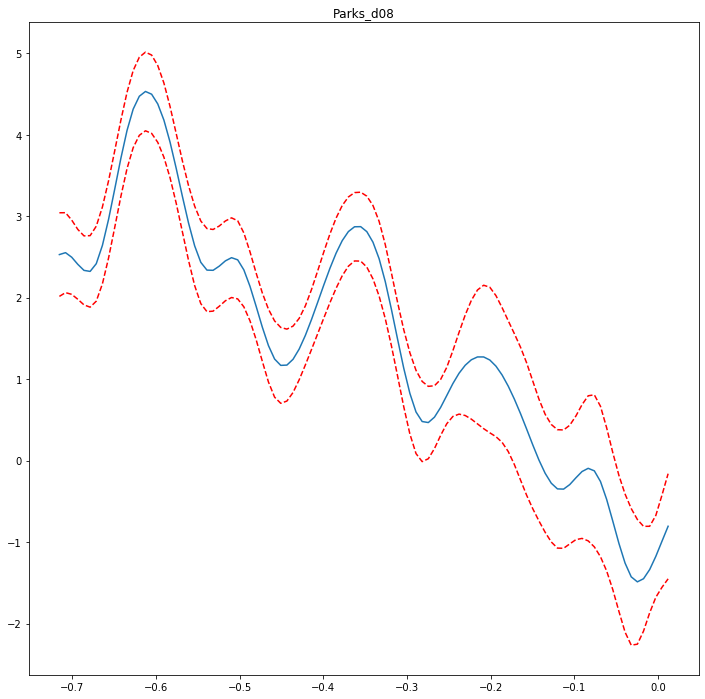

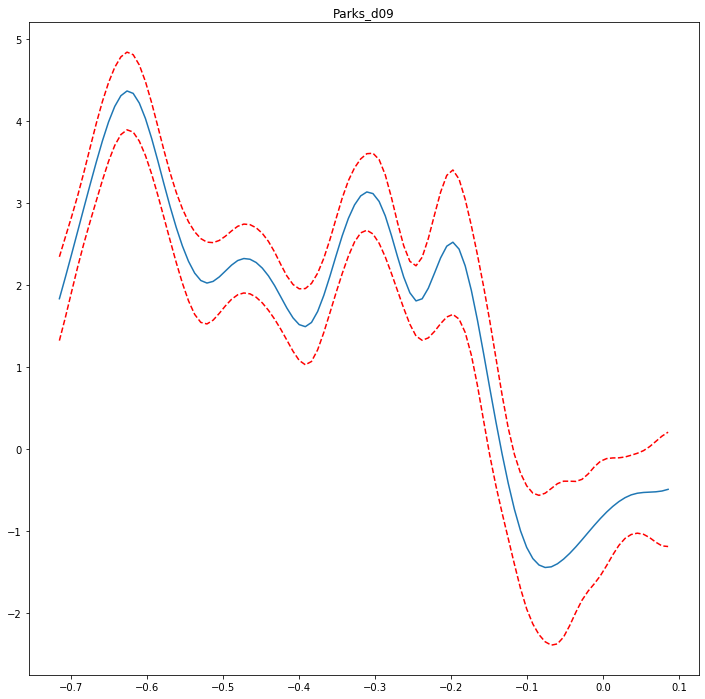

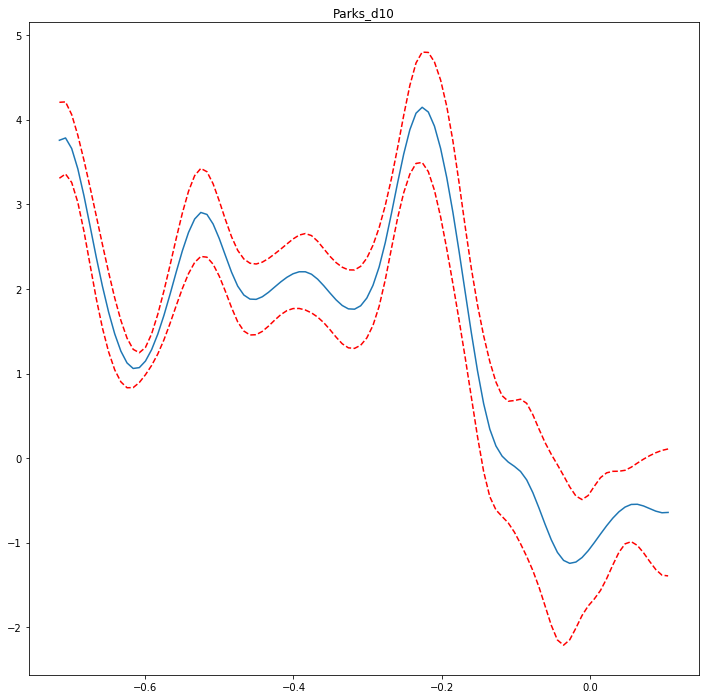

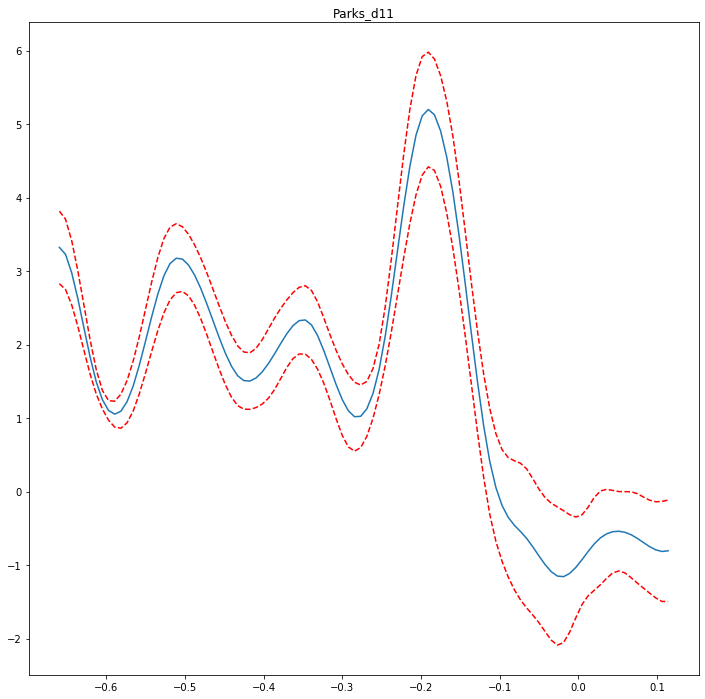

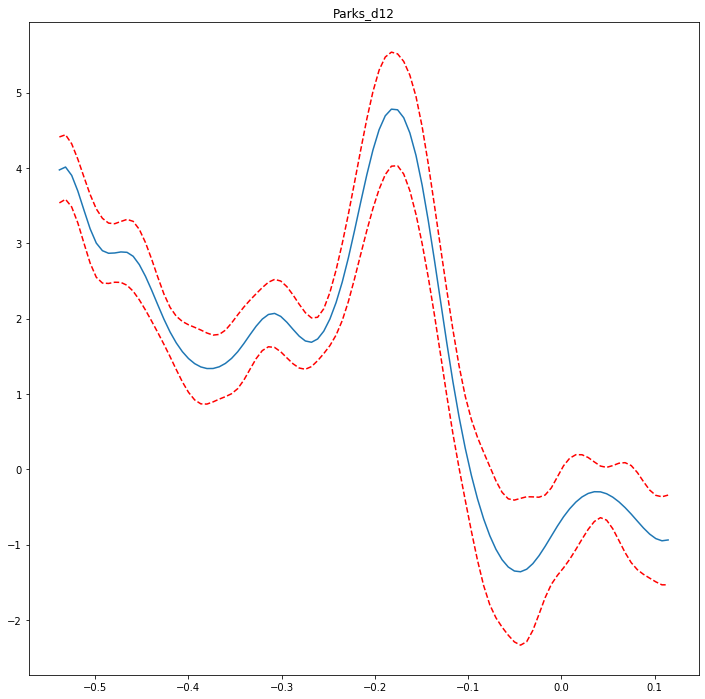

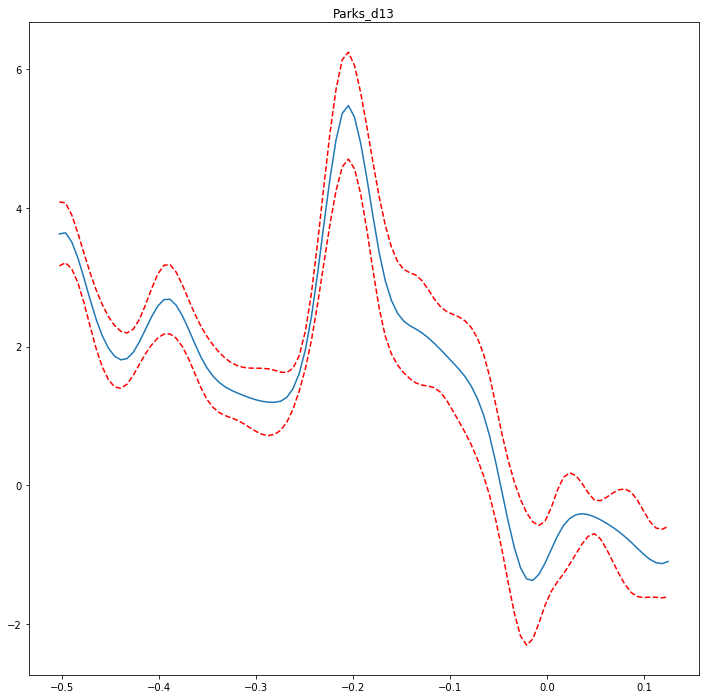

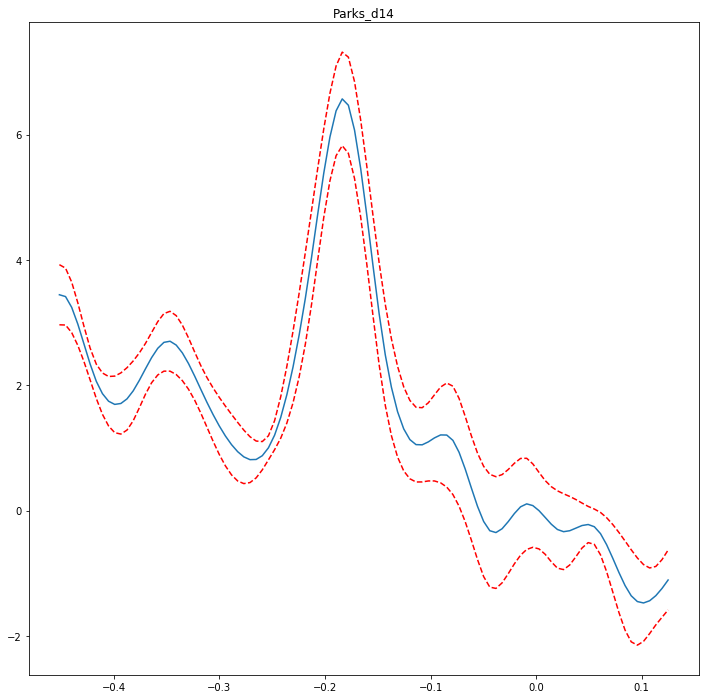

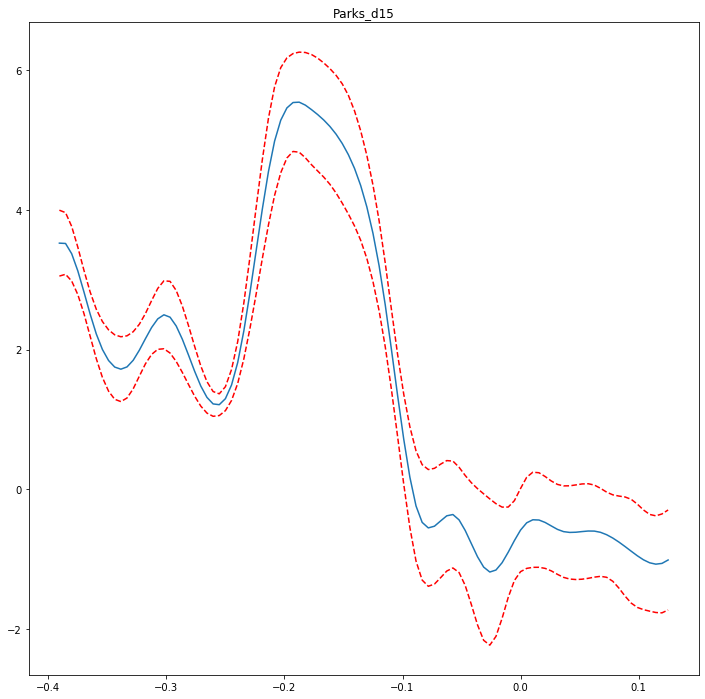

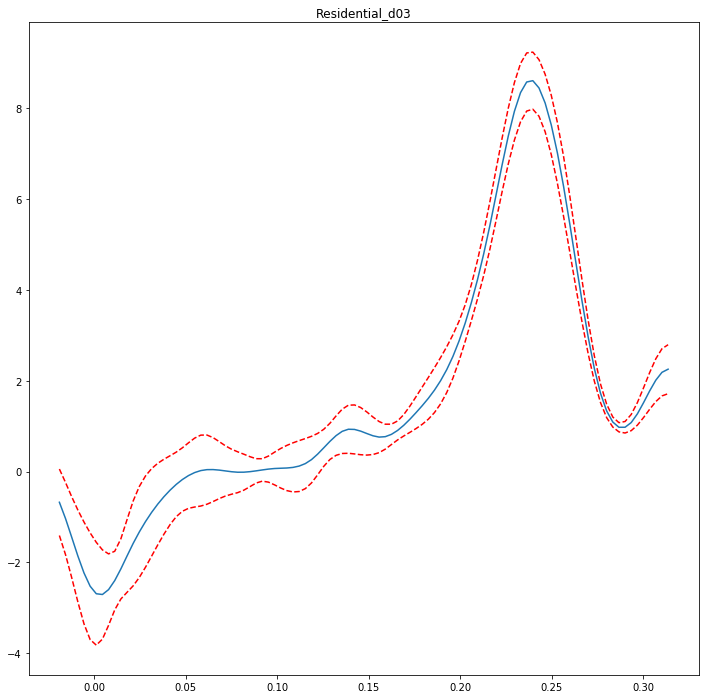

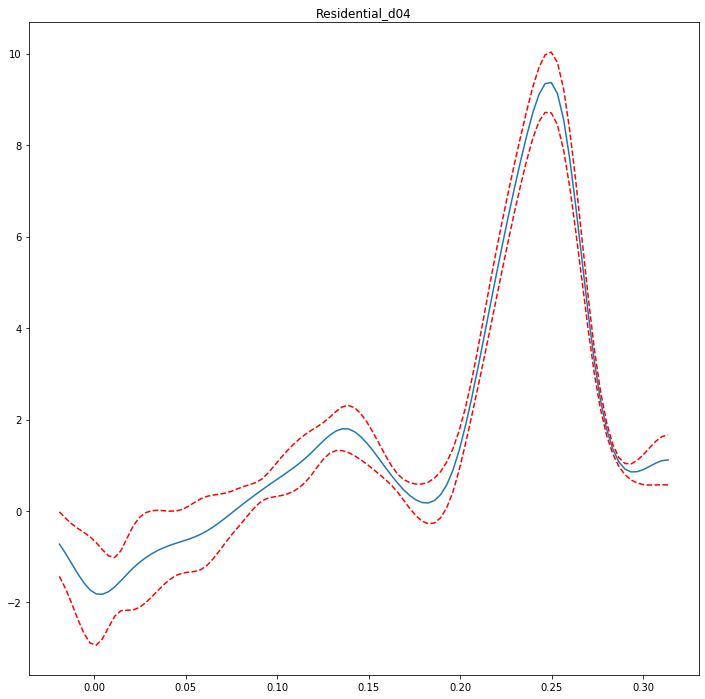

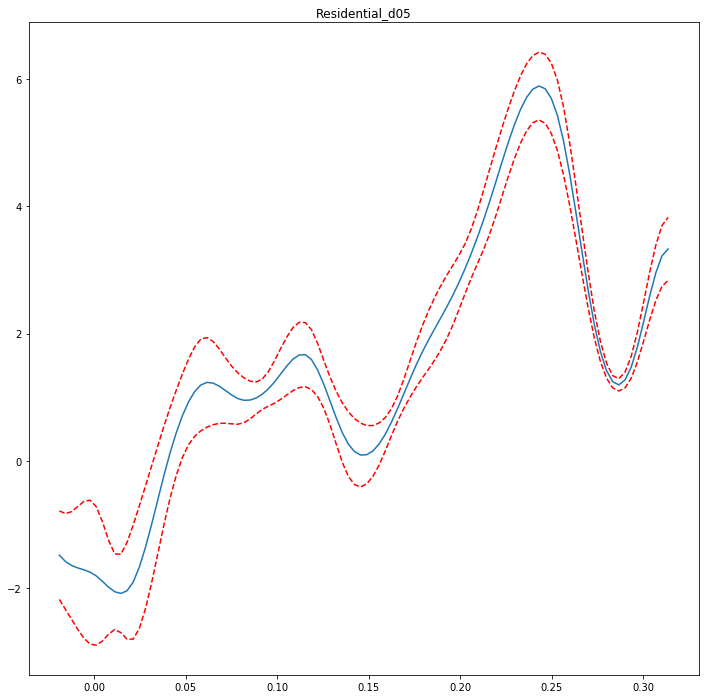

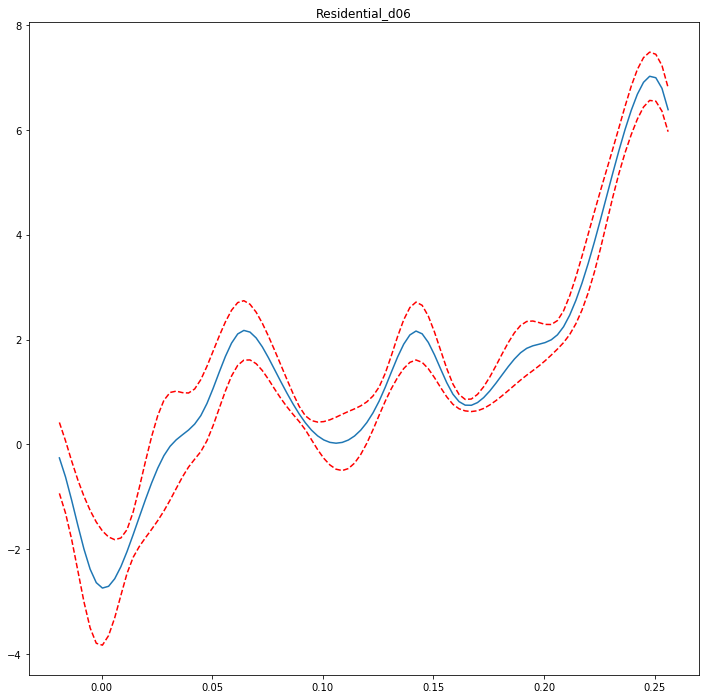

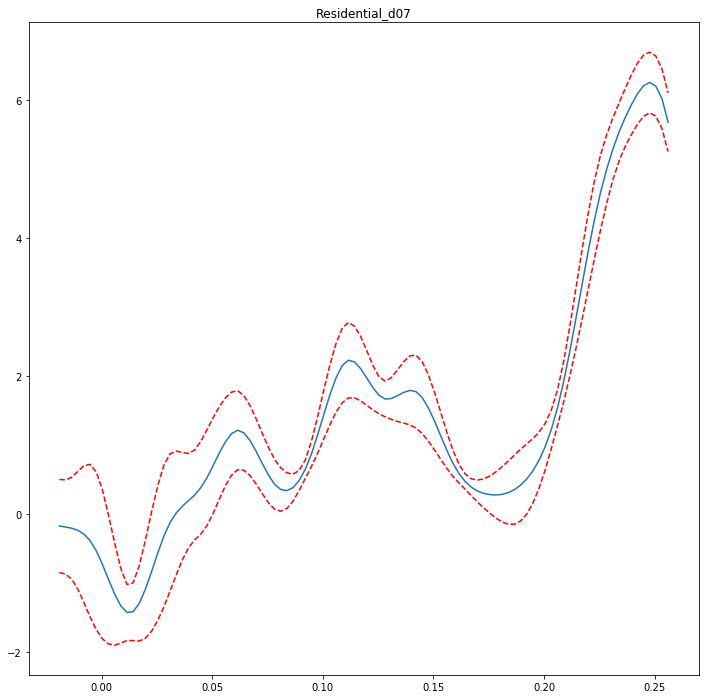

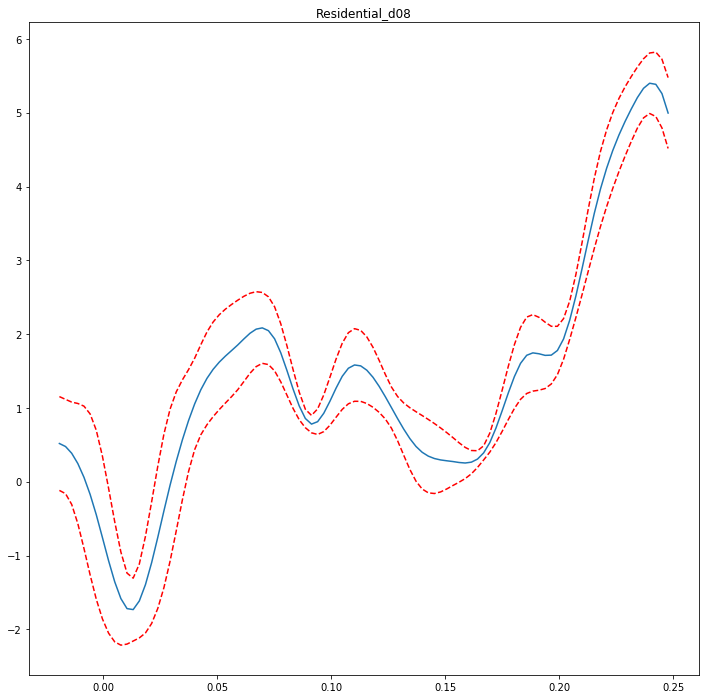

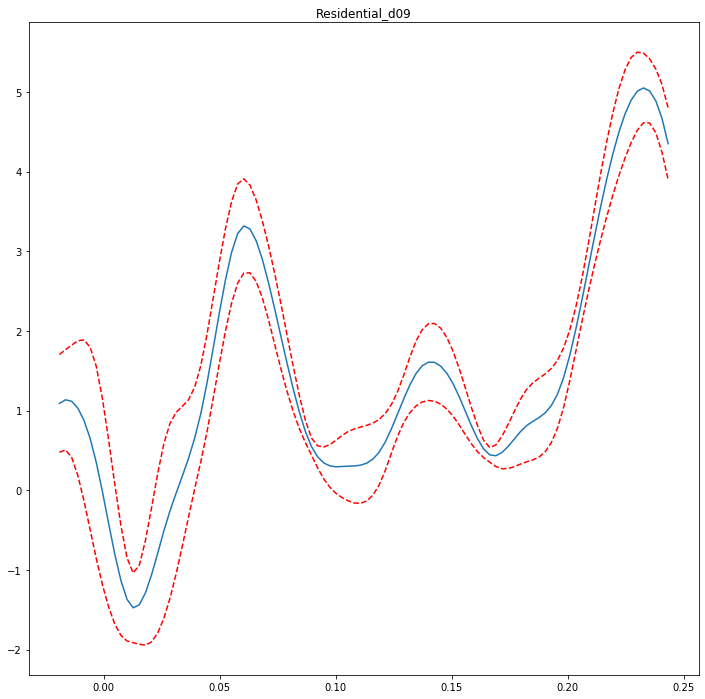

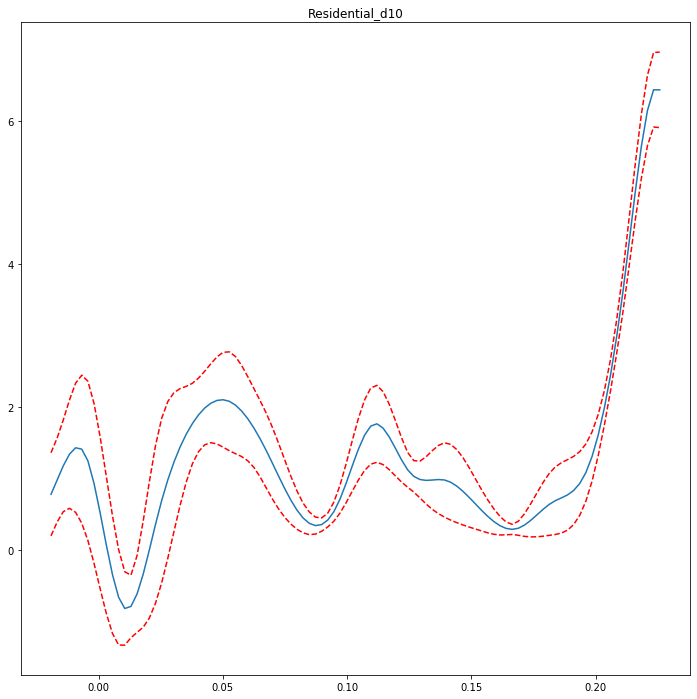

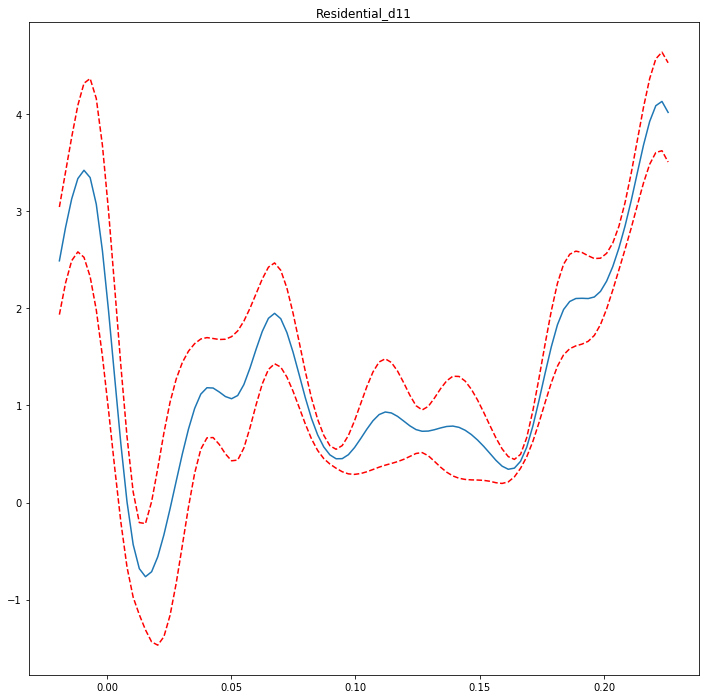

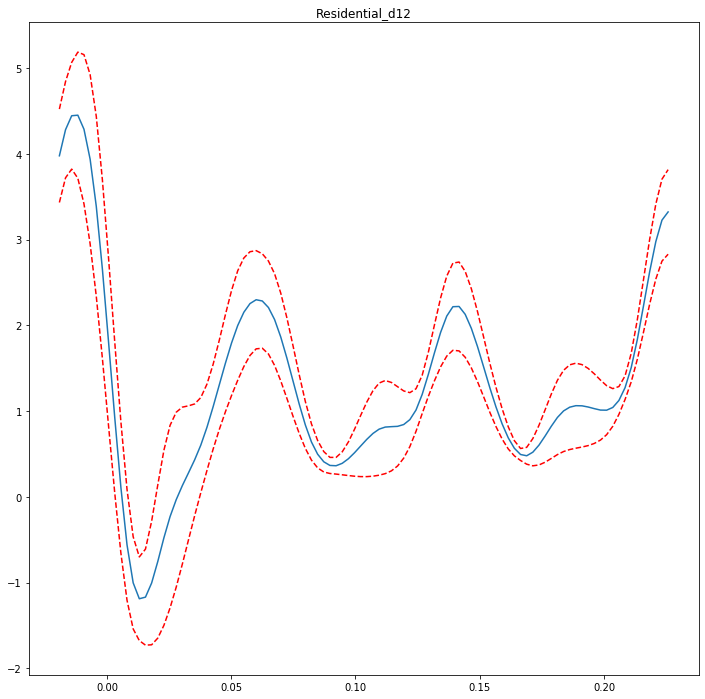

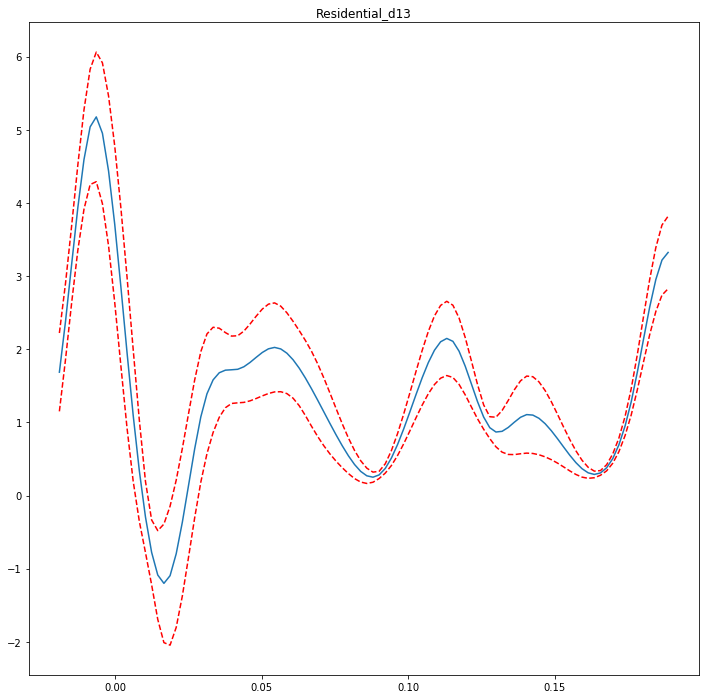

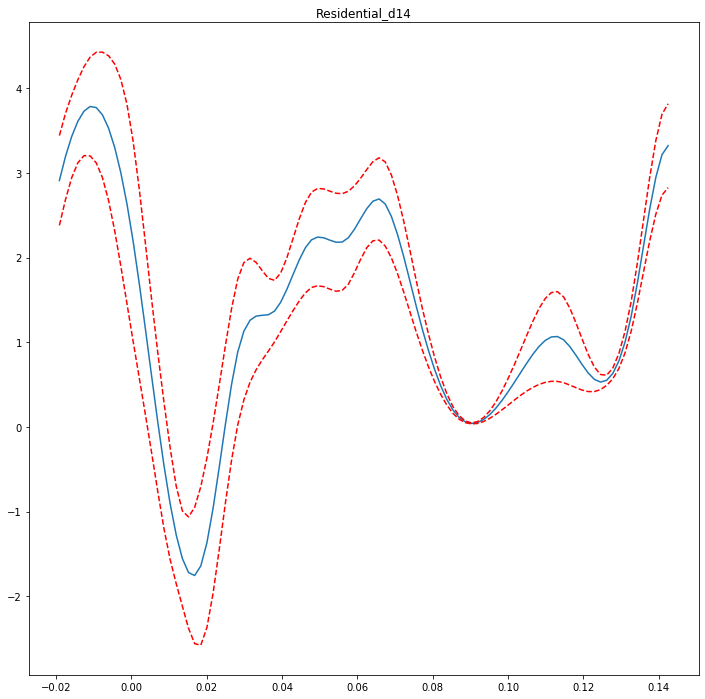

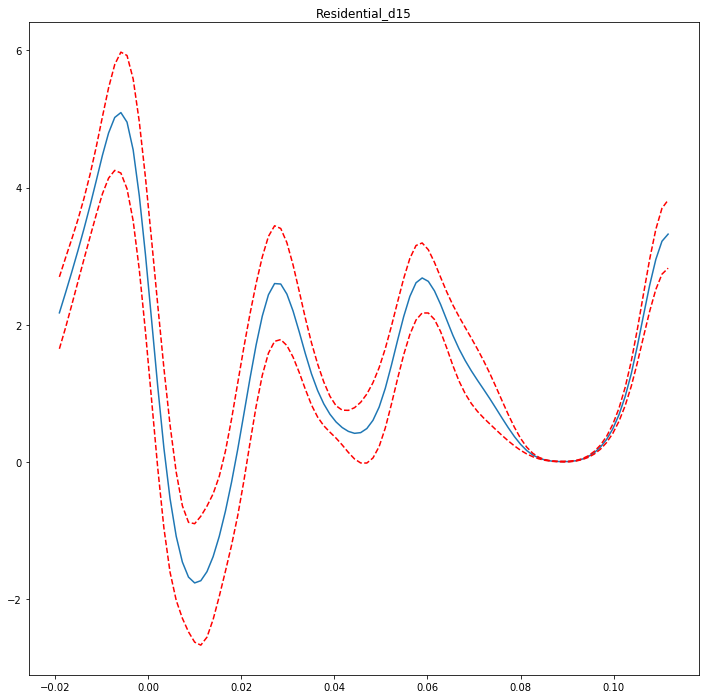

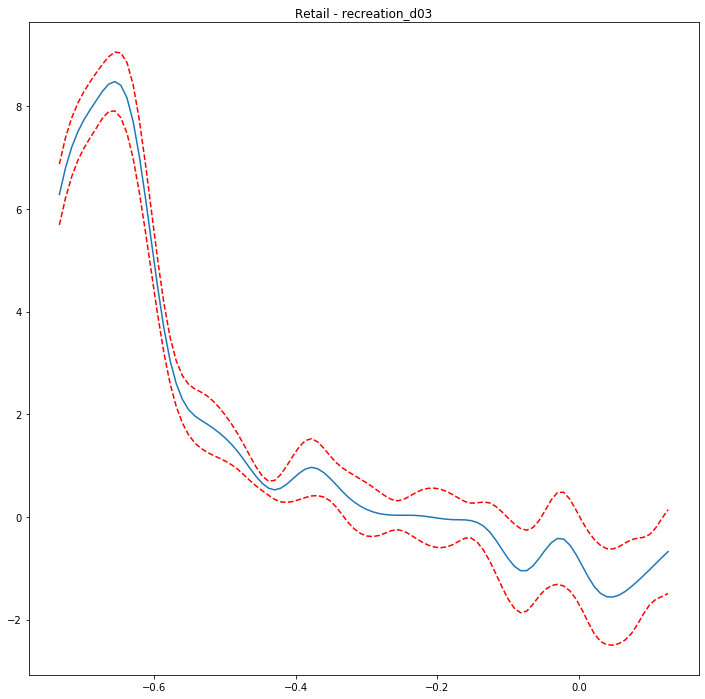

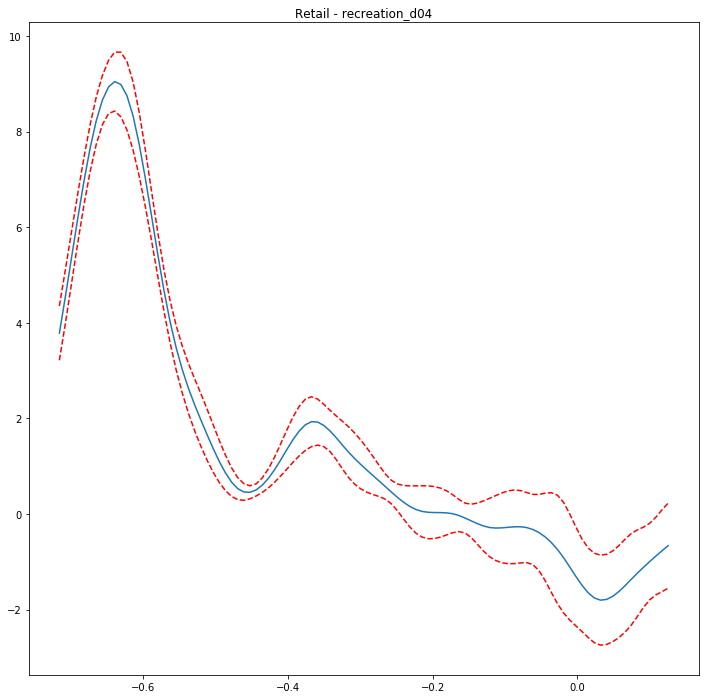

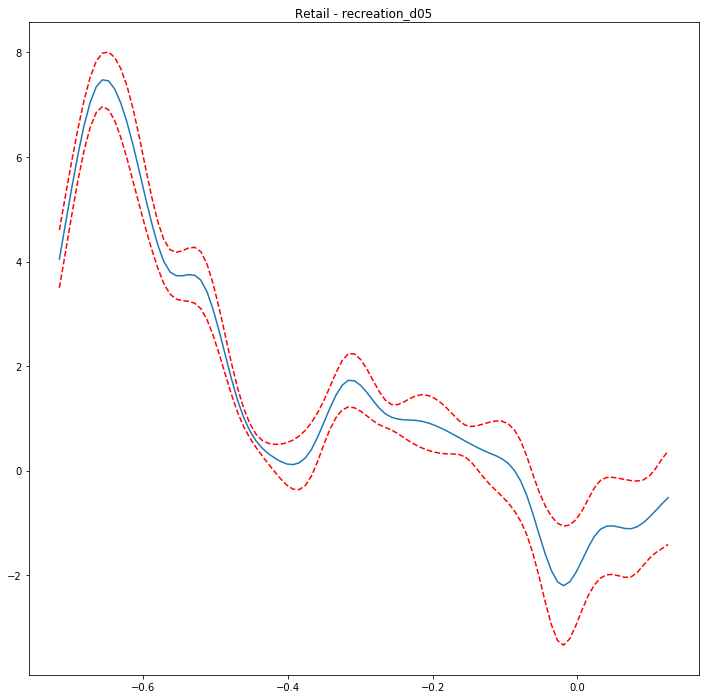

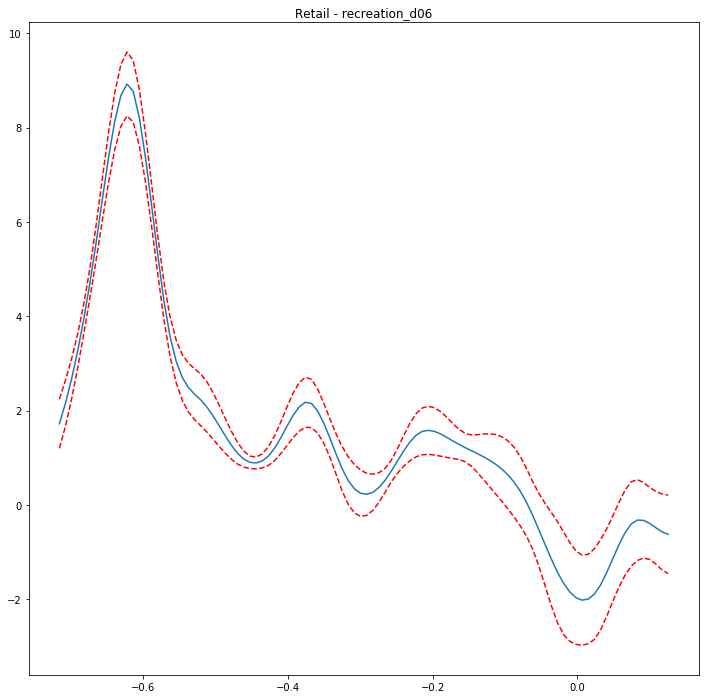

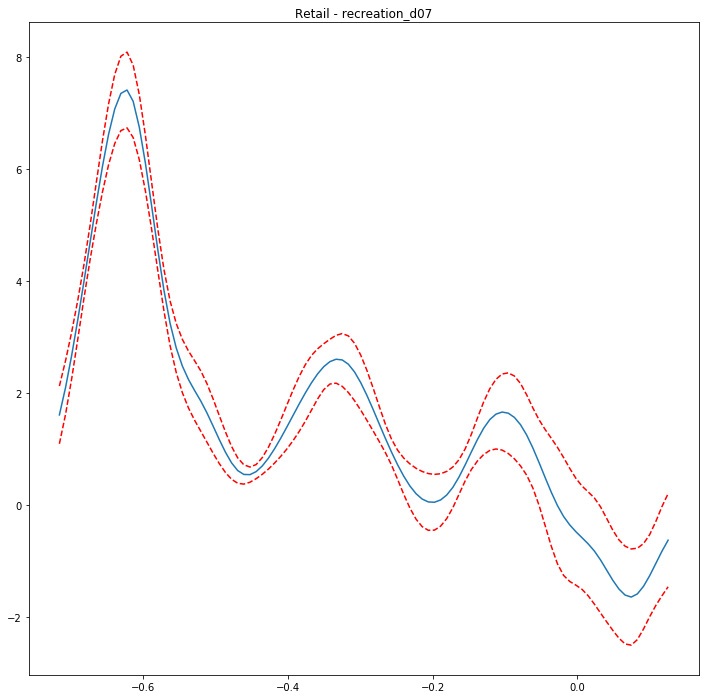

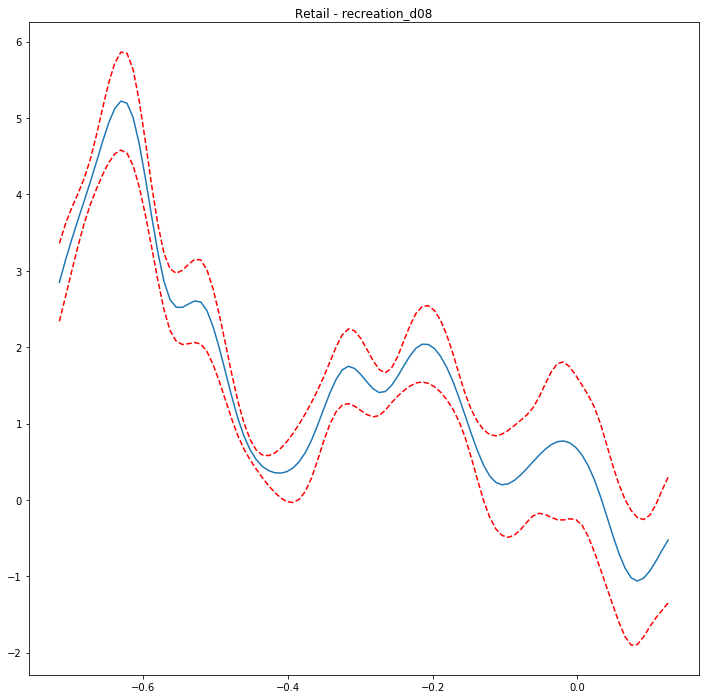

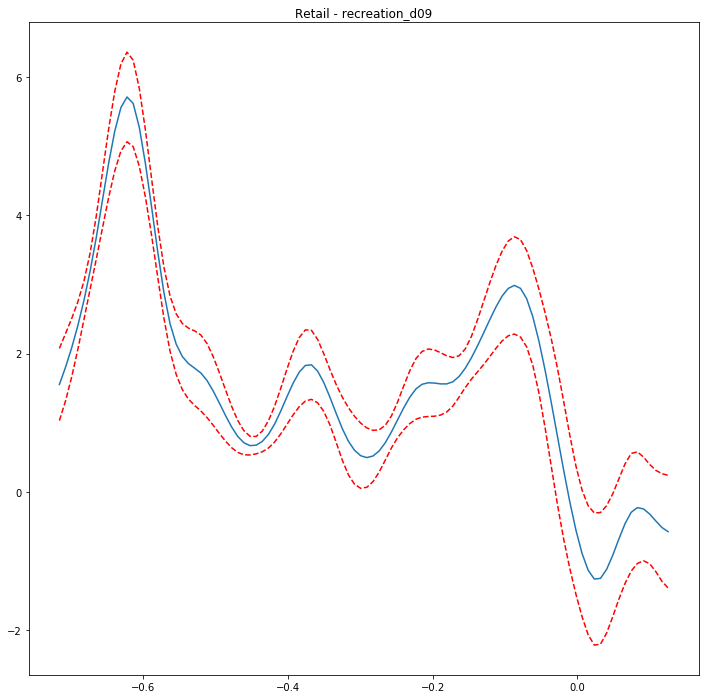

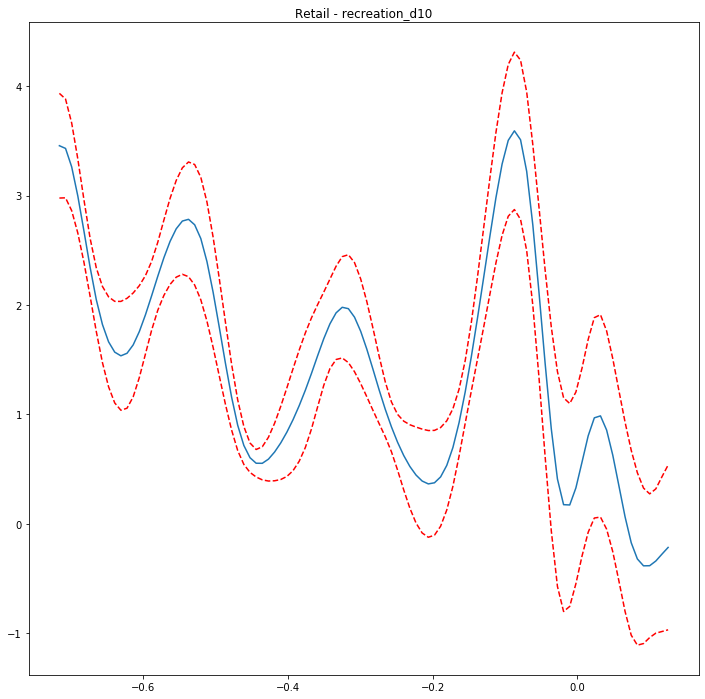

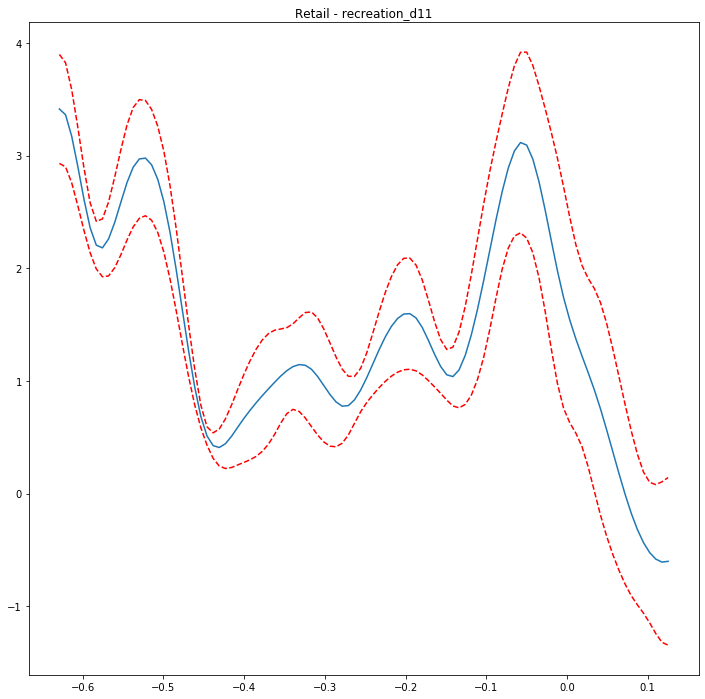

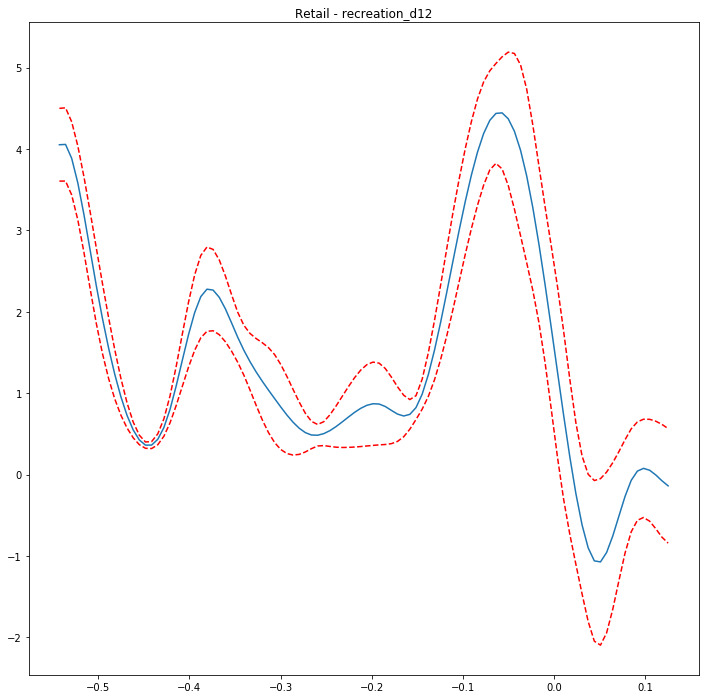

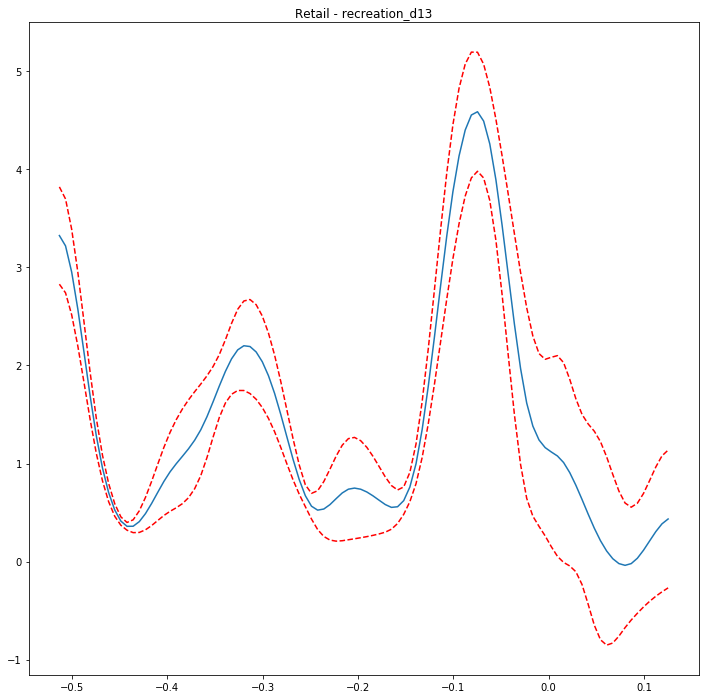

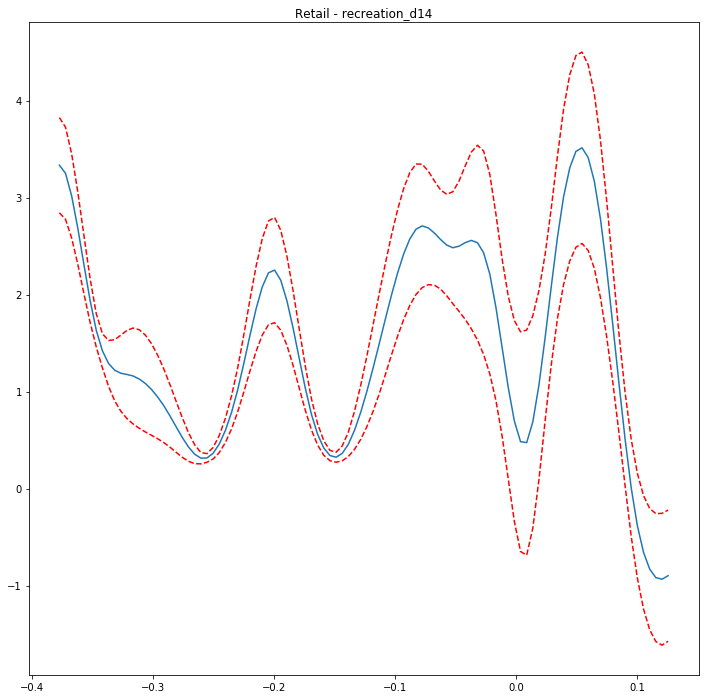

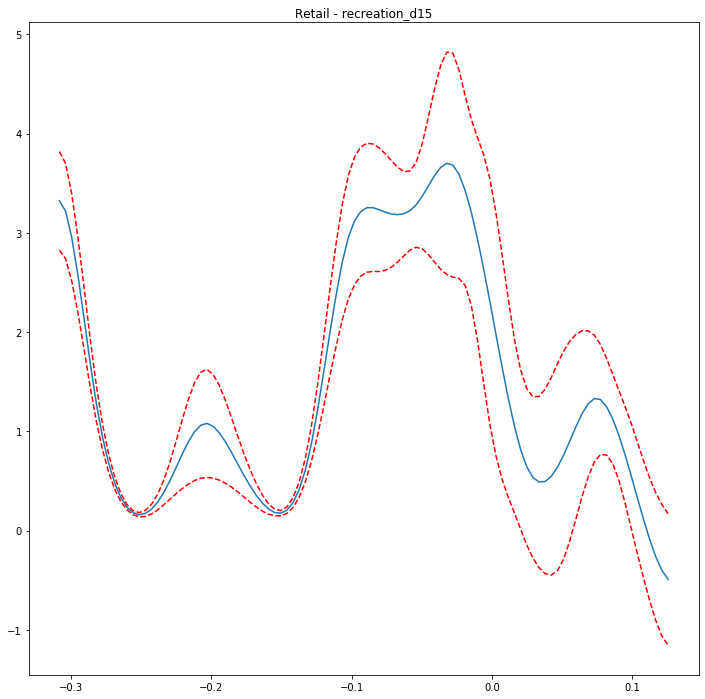

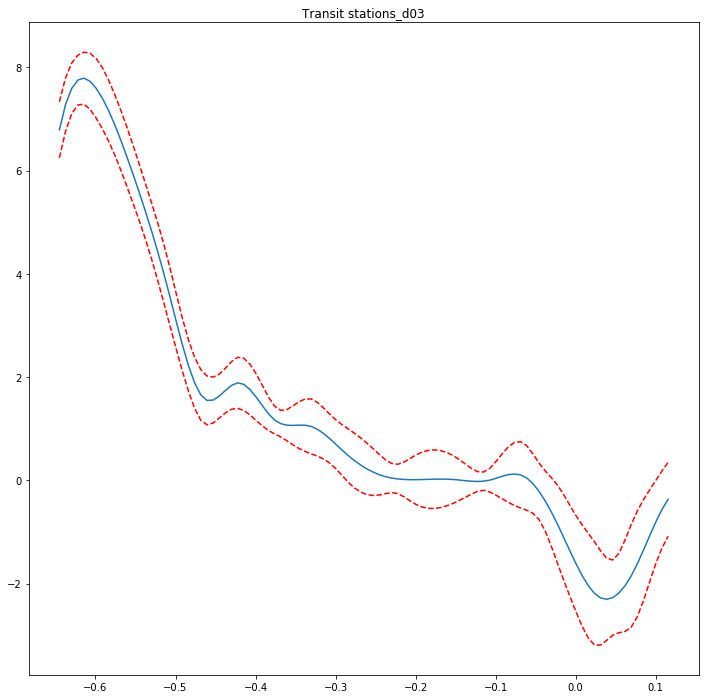

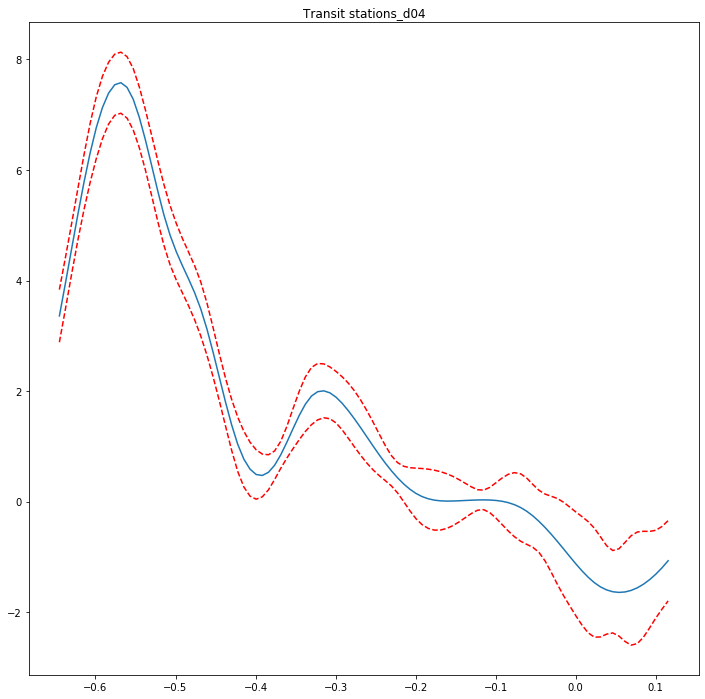

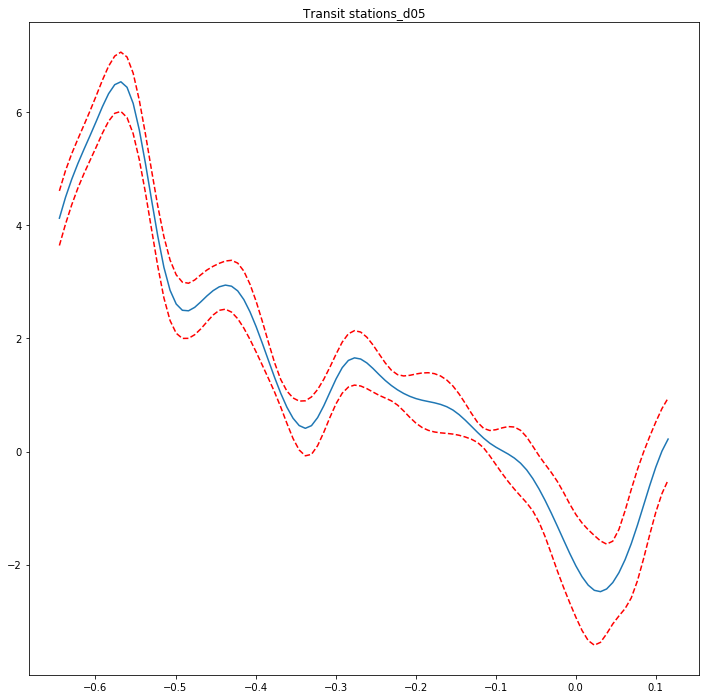

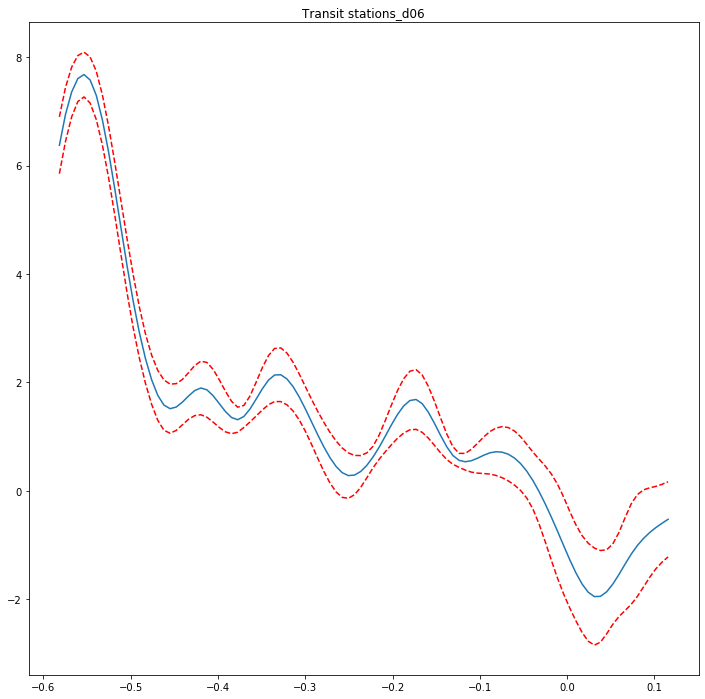

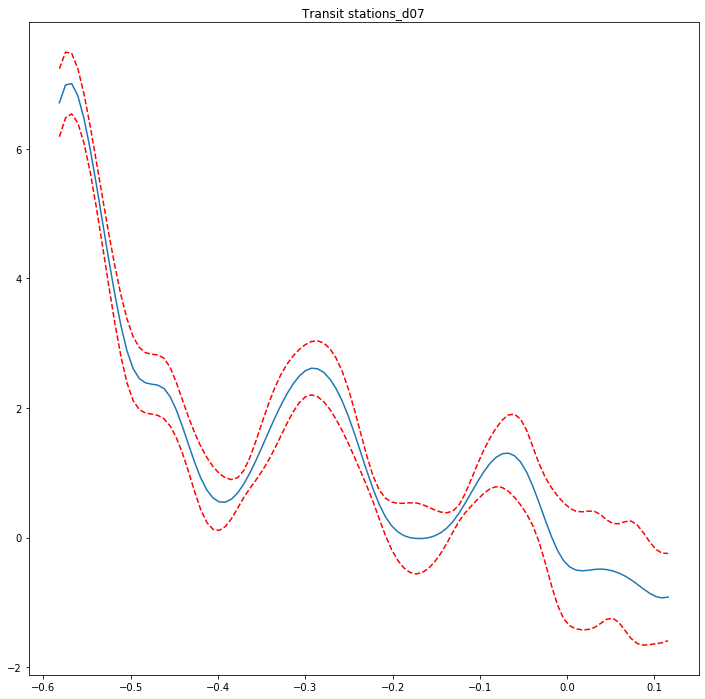

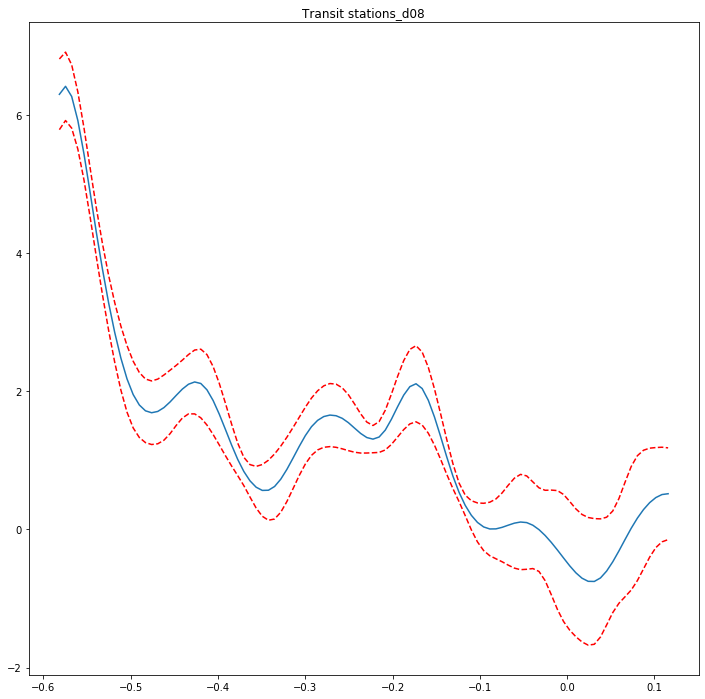

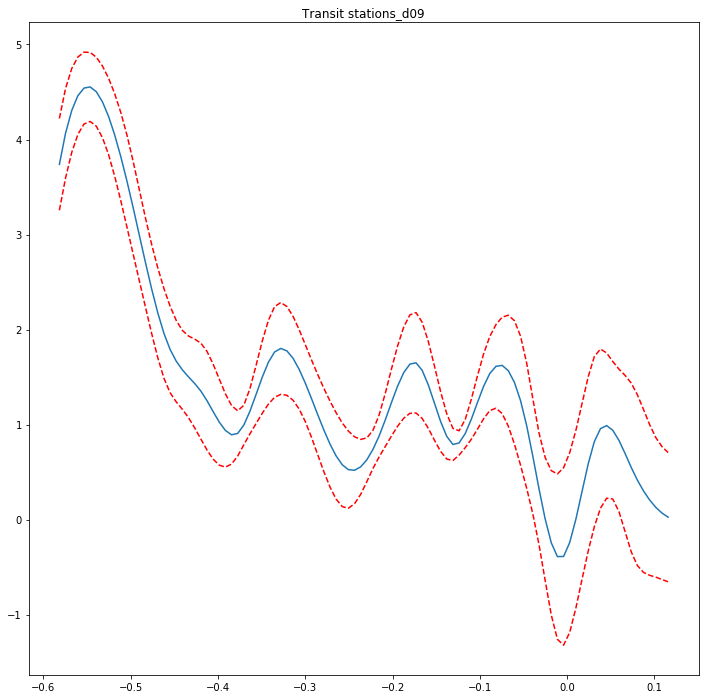

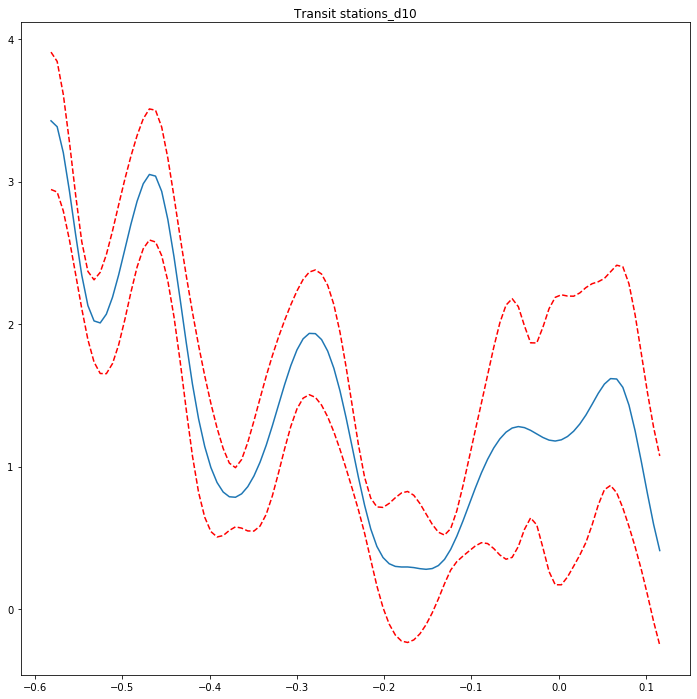

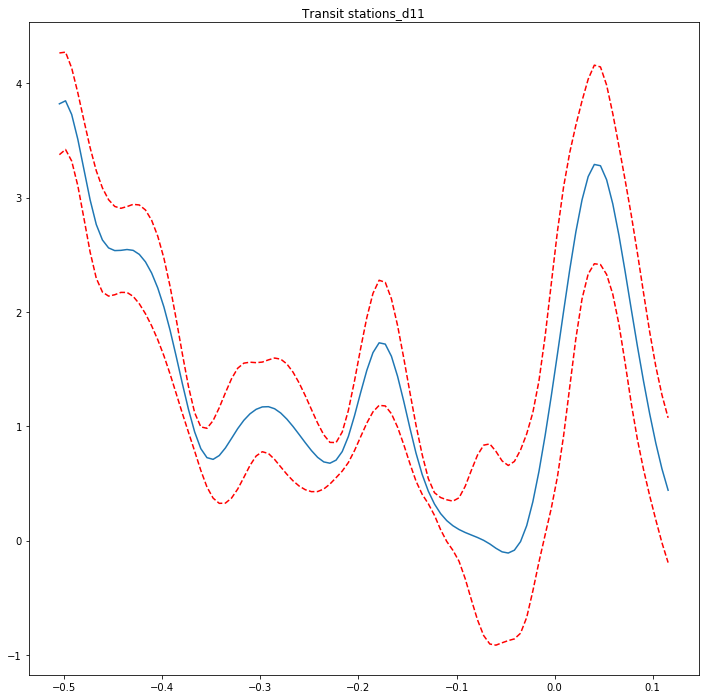

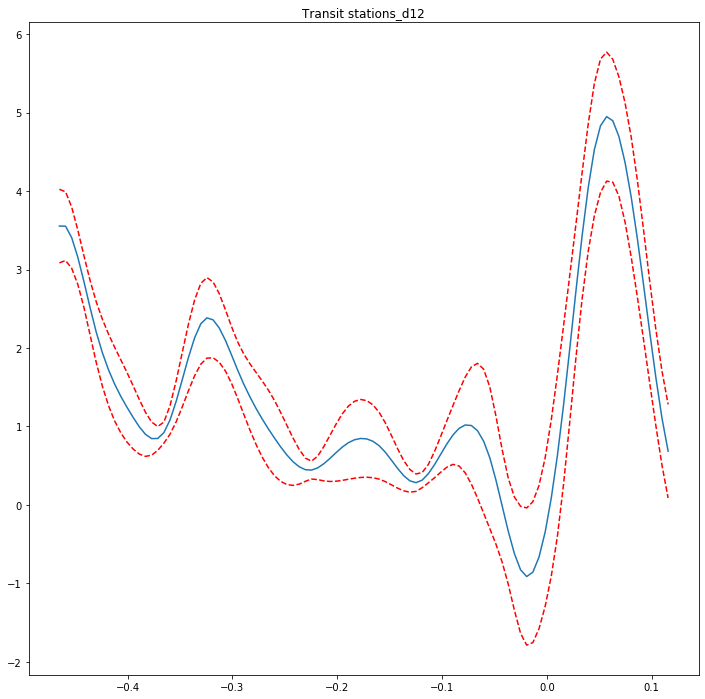

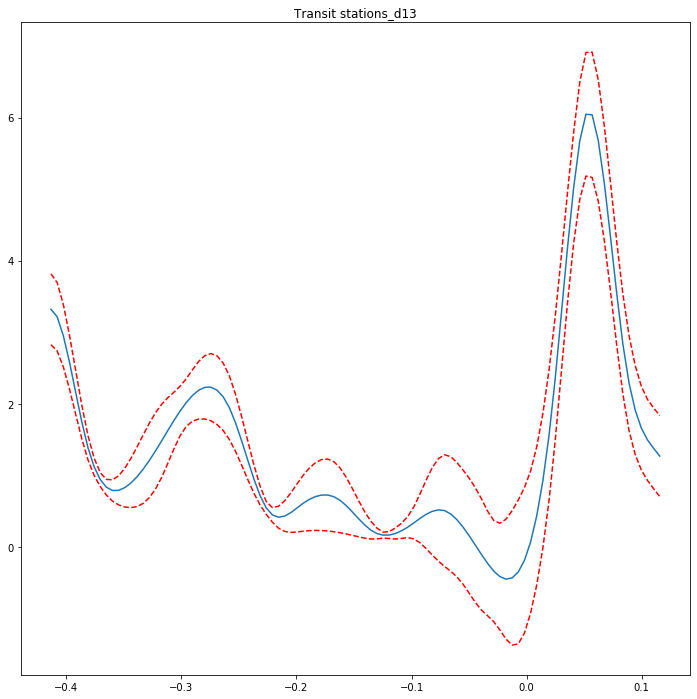

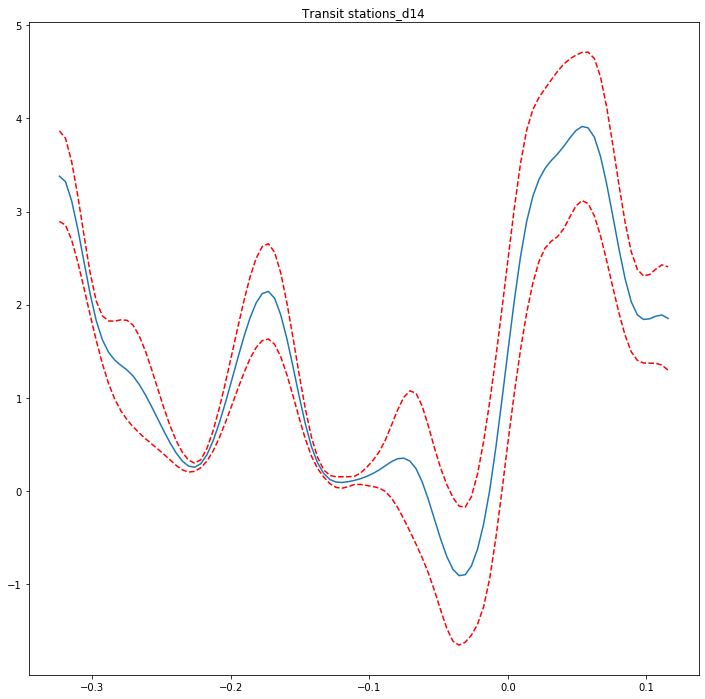

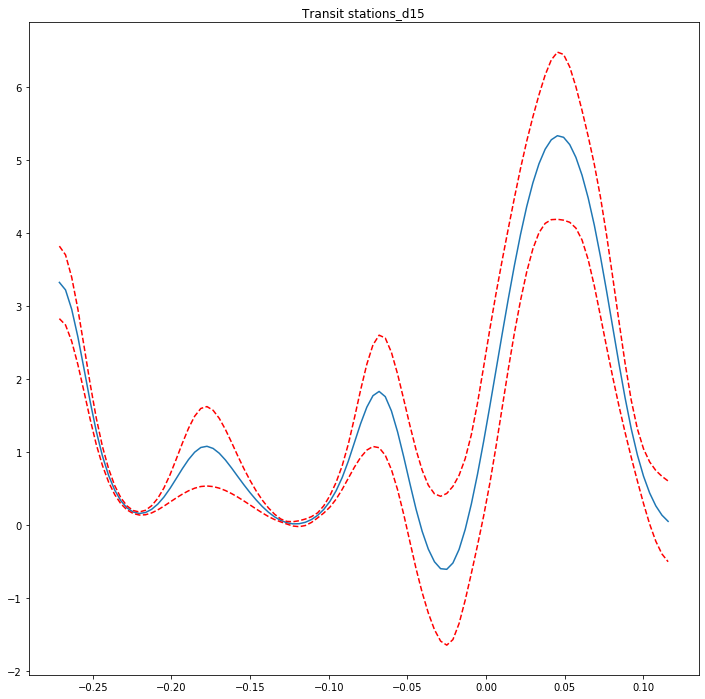

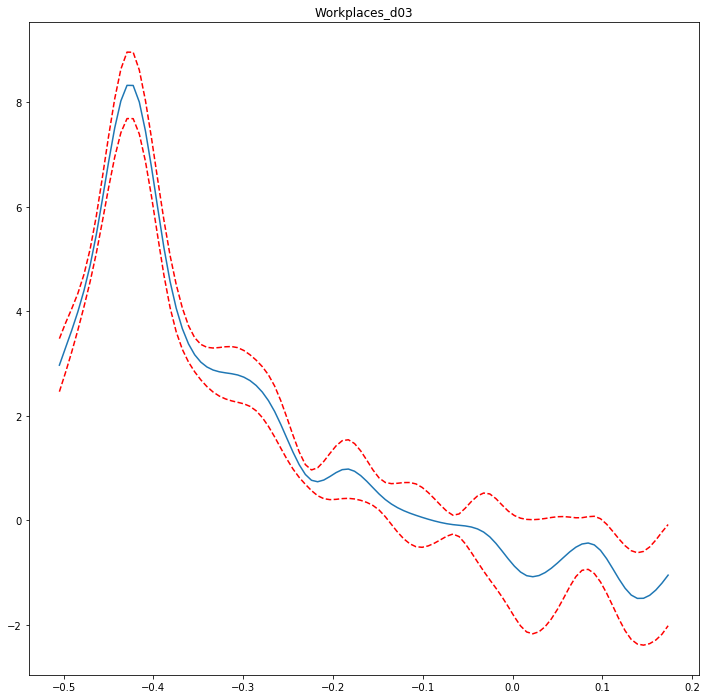

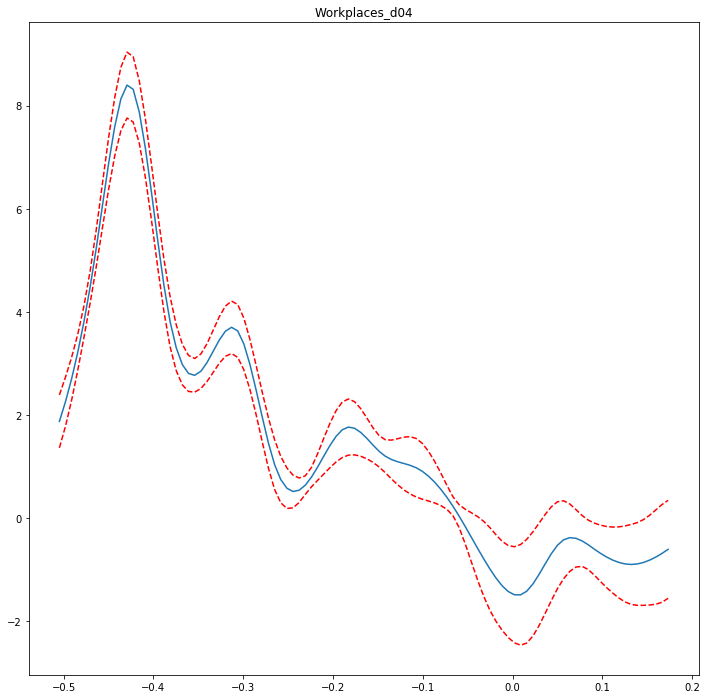

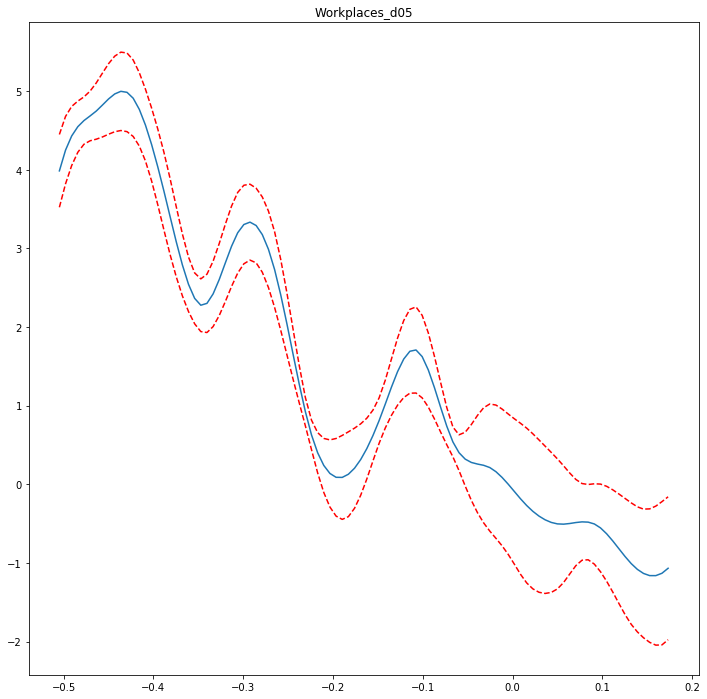

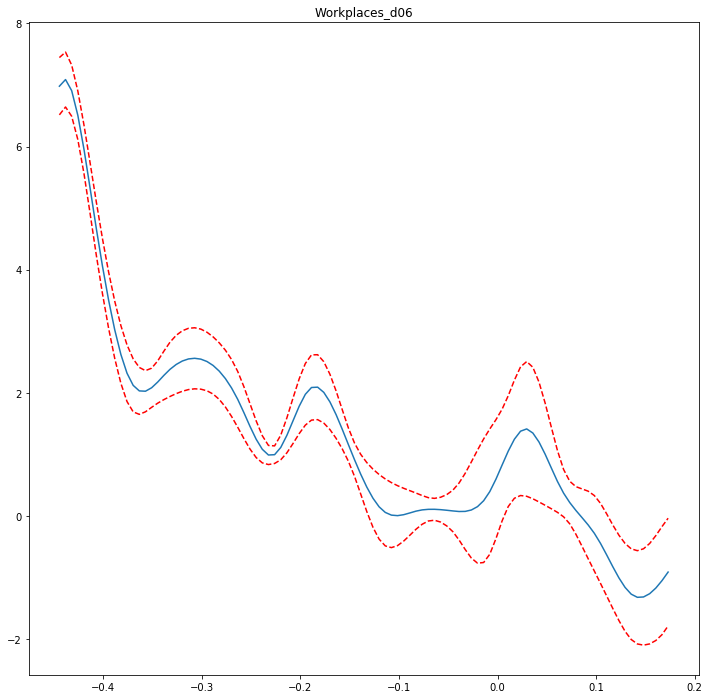

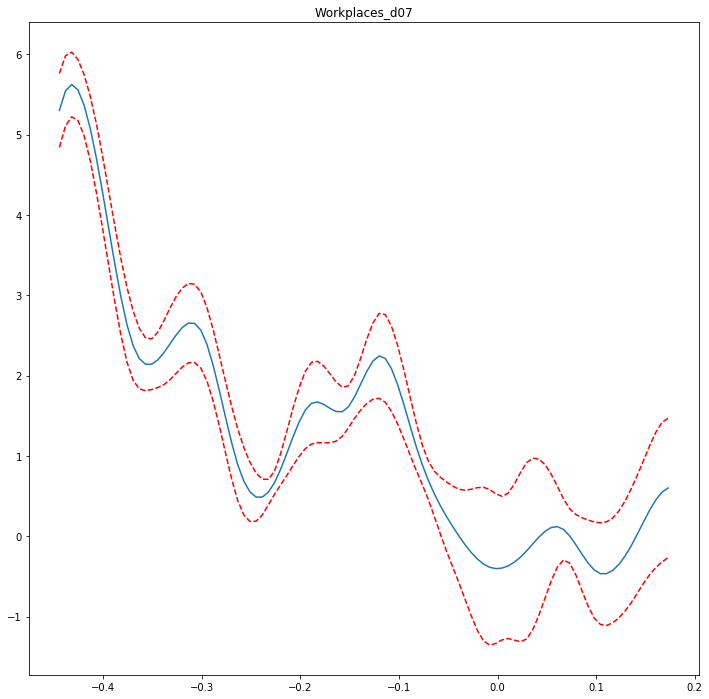

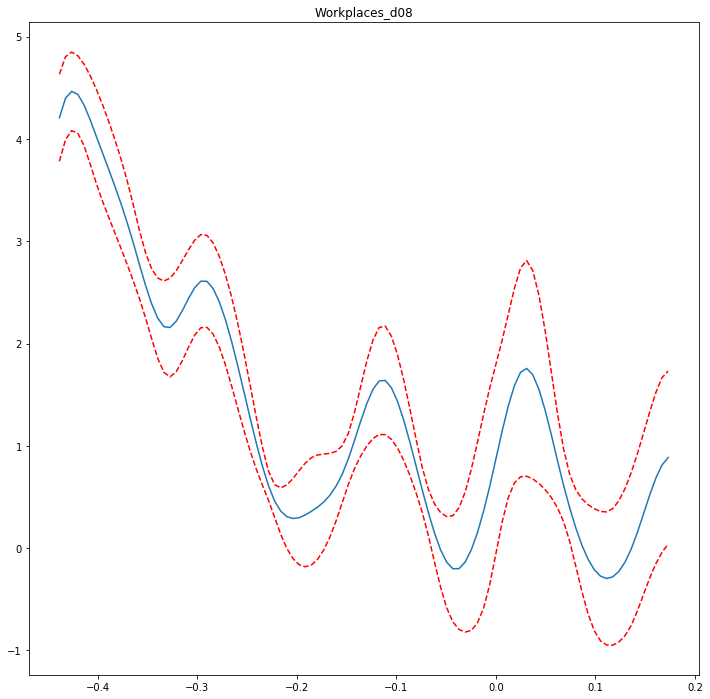

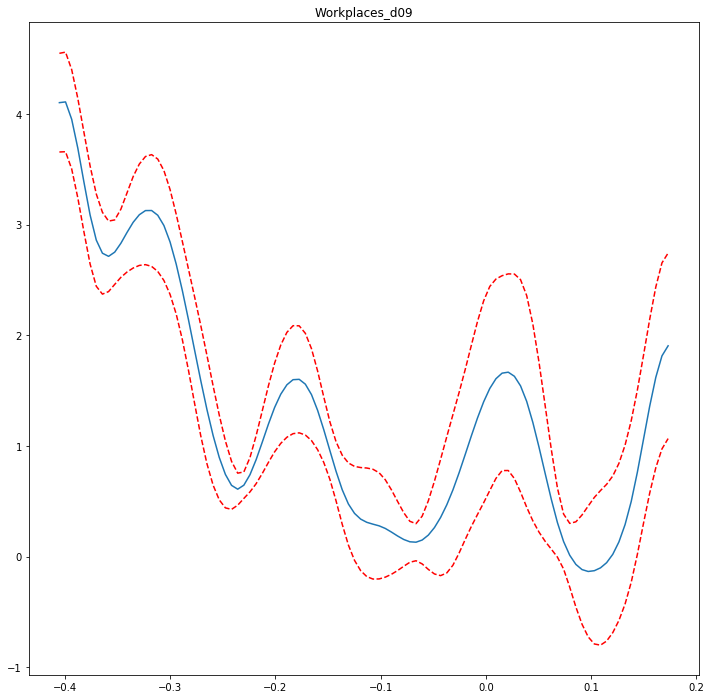

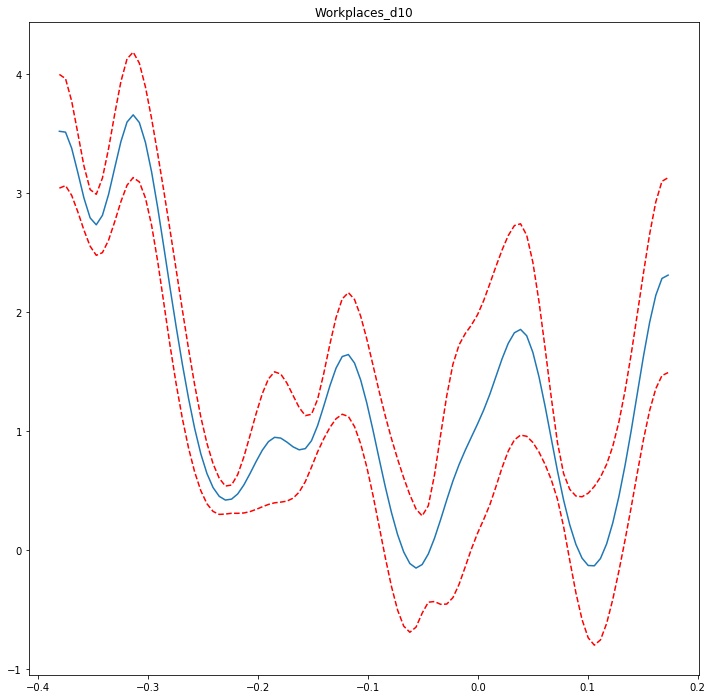

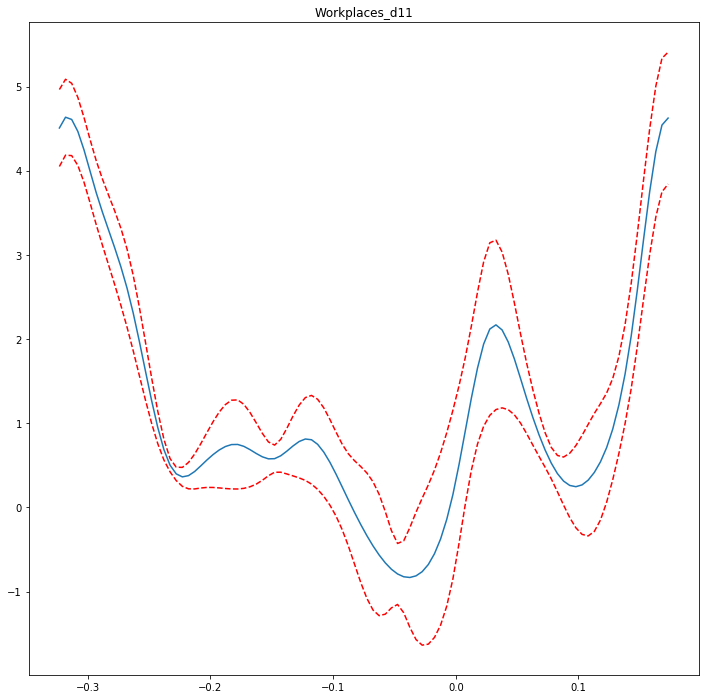

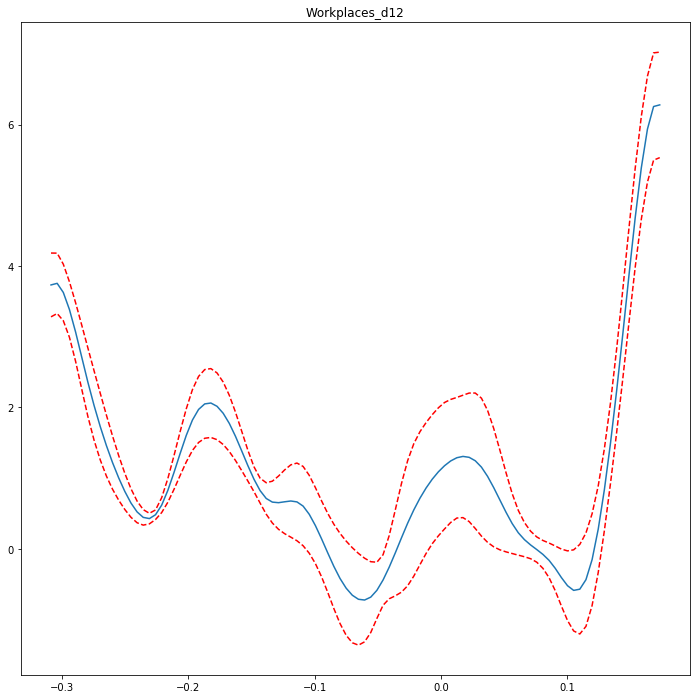

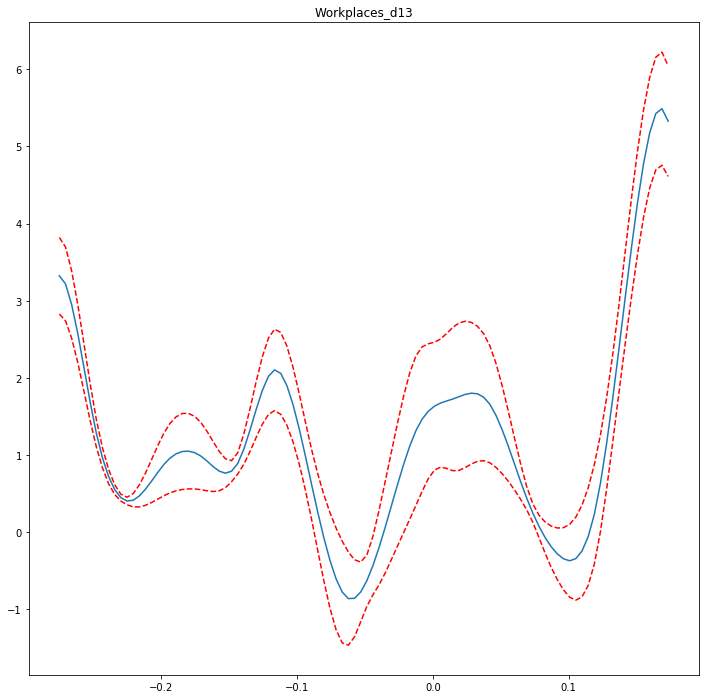

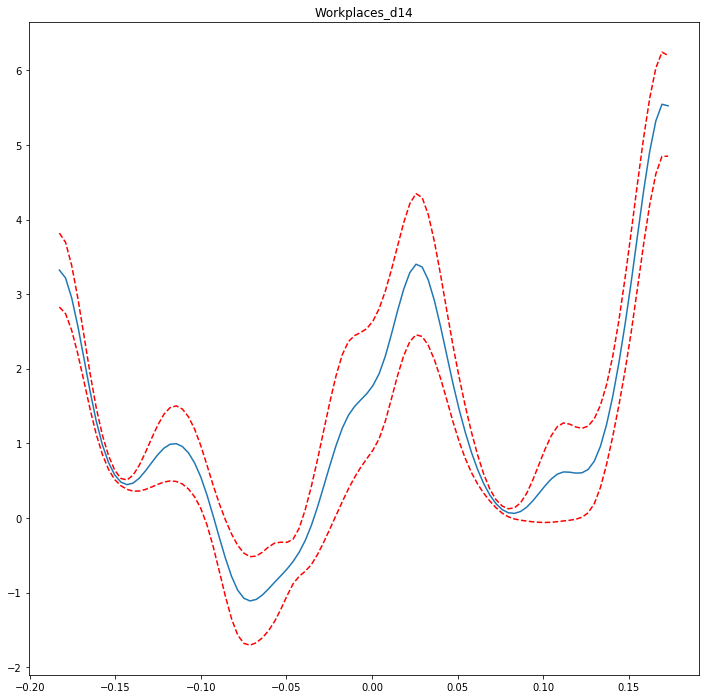

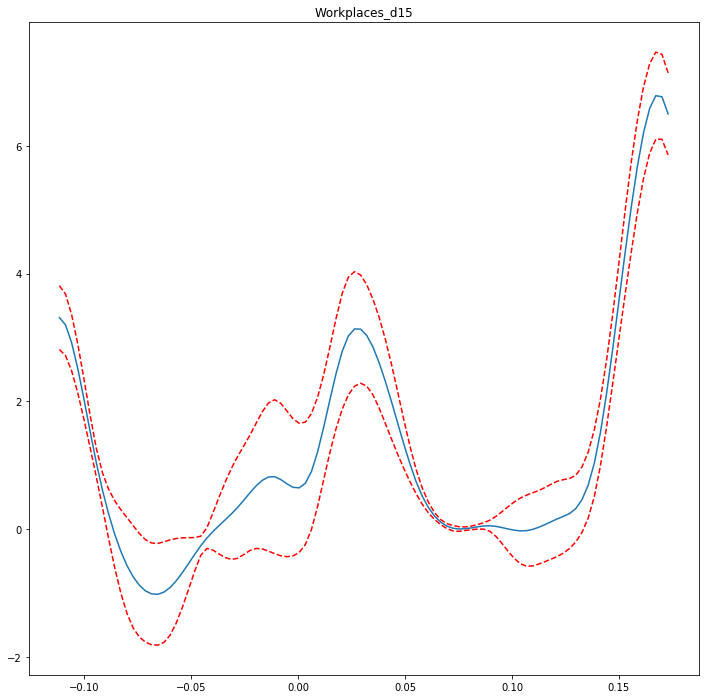

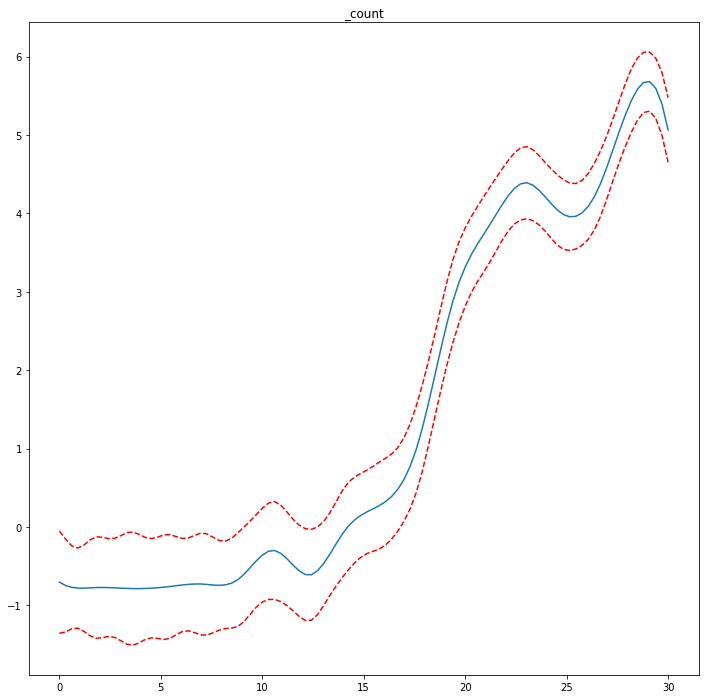

In [102]:
import matplotlib.pyplot as plt


for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    fig, ax = plt.subplots(figsize=(12, 12))
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(df.columns[i])
    plt.show()

